In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from gensim.models import Word2Vec
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense,Dropout,BatchNormalization, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import StratifiedKFold

In [2]:
df = pd.read_csv('dataset_skripsi_clean_labeling_fix.csv',delimiter=';')
df

Unnamed: 0                                               text     label
0               0            terimakasih tonton langsung lewat menit   Neutral
1               1             keren panji berani botak kritis apatis  Negative
2               2           prabowo masuk akal titik gagasanya muter  Positive
3               3  refleksi anies refleksi ganjar pranowo refleks...   Neutral
4               4  menit prabowo bilang aset mandek kuasa iya tol...   Neutral
...           ...                                                ...       ...
17823       17965  kandidat ganjar pranowo calon presiden ideal p...   Neutral
17824       17966  tertawa data bps yohanes mnjabat tingkat miski...   Neutral
17825       17968  nampancoklat orang jawa tengah kadrun masuk ke...  Negative
17826       17969  prabowo halang urus rumah tanga beranta urus n...  Negative
17827       17970  prabowo calon presiden prabowo kerja capai target   Neutral

[17828 rows x 3 columns]

In [3]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

Unnamed: 0                                               text     label
0               0            terimakasih tonton langsung lewat menit   Neutral
1               1             keren panji berani botak kritis apatis  Negative
2               2           prabowo masuk akal titik gagasanya muter  Positive
3               3  refleksi anies refleksi ganjar pranowo refleks...   Neutral
4               4  menit prabowo bilang aset mandek kuasa iya tol...   Neutral
...           ...                                                ...       ...
17823       17965  kandidat ganjar pranowo calon presiden ideal p...   Neutral
17824       17966  tertawa data bps yohanes mnjabat tingkat miski...   Neutral
17825       17968  nampancoklat orang jawa tengah kadrun masuk ke...  Negative
17826       17969  prabowo halang urus rumah tanga beranta urus n...  Negative
17827       17970  prabowo calon presiden prabowo kerja capai target   Neutral

[17828 rows x 3 columns]

In [4]:
df['label'].value_counts()

label
Neutral     9047
Negative    4553
Positive    4228
Name: count, dtype: int64

In [5]:
import multiprocessing
from time import time
cores = multiprocessing.cpu_count() # Count the number of cores in a computer
print("Total Core Computer : {} Core".format(cores))

Total Core Computer : 8 Core


In [6]:
from gensim.models import Word2Vec
tokenized_data = df['text'].apply(lambda x: x.split())  # tokenizing
model_w2v = Word2Vec(
    tokenized_data,
    vector_size=100,  # desired no. of features/independent variables
    window=5,  # context window size
    min_count=2,  # Ignores all words with total frequency lower than 2.
    sg=0,  # 1 for skip-gram model
    hs=0,
    negative=20,  # for negative sampling
    workers=cores - 4,  # no.of cores
    epochs=100
)
print(model_w2v)
print("Vocabulary Length:", len(model_w2v.wv.key_to_index))

Word2Vec<vocab=5458, vector_size=100, alpha=0.025>
Vocabulary Length: 5458


In [7]:
t = time()

model_w2v.build_vocab(tokenized_data, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

Time to build vocab: 0.0 mins


In [8]:
train_mw2v = model_w2v.train(tokenized_data, total_examples=len(df['text']), epochs=50, report_delay=1)
print(train_mw2v)
print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

(5901205, 7902400)
Time to build vocab: 0.24 mins


In [9]:
# Tokenize text data
max_len = 50
tokenizer = Tokenizer(num_words=len(model_w2v.wv.key_to_index))
tokenizer.fit_on_texts(df['text'])
text = tokenizer.texts_to_sequences(df['text'])
# Pad sequences
text = pad_sequences(text, maxlen=max_len, padding='post', truncating='post')

In [10]:
num_words = 50
embedding_dim = 100
embedding_matrix = np.zeros((num_words, embedding_dim))

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))  # Initialize with zeros
for word, i in tokenizer.word_index.items():
    if word in model_w2v.wv.key_to_index:
        embedding_matrix[i] = model_w2v.wv[word]

In [11]:
X=df['text']
encoder = LabelEncoder()
y = encoder.fit_transform(df['label'])

In [12]:
# Perform SMOTE oversampling on training data
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(text, y)

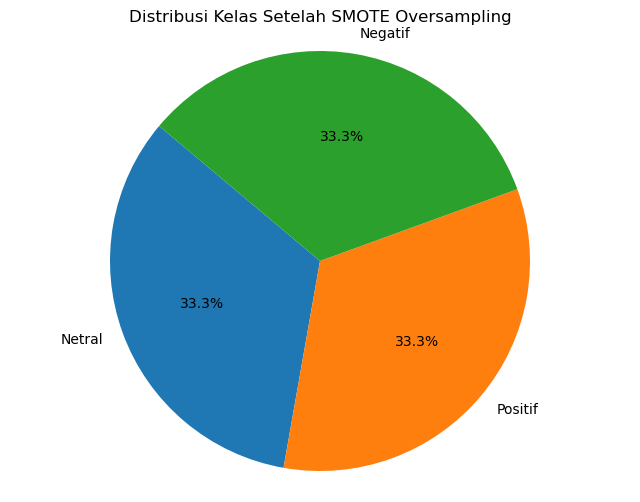

In [13]:
class_counts = pd.Series(y_train_smote).value_counts()

# Daftar label untuk klasifikasi (0=netral, 1=positif, 2=negatif)
labels = ['Netral', 'Positif', 'Negatif']

# Plot diagram lingkaran
plt.figure(figsize=(8, 6))
plt.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribusi Kelas Setelah SMOTE Oversampling')
plt.axis('equal')  # Membuat diagram lingkaran menjadi lingkaran
plt.show()

In [14]:
pd.value_counts(y_train_smote)

C:\Users\ekaad\AppData\Local\Temp\ipykernel_7376\585918252.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(y_train_smote)


1    9047
0    9047
2    9047
Name: count, dtype: int64

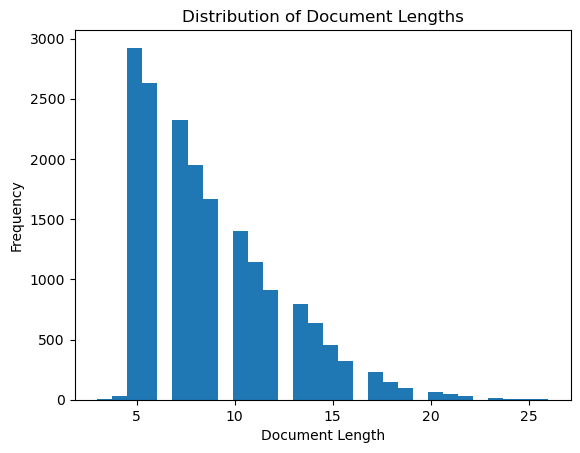

In [15]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
# Tokenize text to get lengths
tokenized_text = tokenizer.texts_to_sequences(df['text'])
lengths = [len(seq) for seq in tokenized_text]

# Plot the distribution
plt.hist(lengths, bins=30)
plt.title('Distribution of Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [16]:
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['label'])
test_df['label'] = label_encoder.transform(test_df['label'])

In [17]:
y_train = to_categorical(train_df['label'])
y_test = to_categorical(test_df['label'])

# CHECK VARIATIONS

Number of Epochs: 10, Test Size: 0.15, Validation Size: 0.15
Fold 1
Epoch 1/10
187/187 [==============================] - 4s 13ms/step - loss: 1.0181 - accuracy: 0.4787 - val_loss: 1.0085 - val_accuracy: 0.4662
Epoch 2/10
187/187 [==============================] - 2s 11ms/step - loss: 0.9865 - accuracy: 0.4928 - val_loss: 0.9840 - val_accuracy: 0.4864
Epoch 3/10
187/187 [==============================] - 2s 11ms/step - loss: 0.9610 - accuracy: 0.5255 - val_loss: 0.9577 - val_accuracy: 0.5228
Epoch 4/10
187/187 [==============================] - 2s 10ms/step - loss: 0.9360 - accuracy: 0.5625 - val_loss: 0.9321 - val_accuracy: 0.5667
Epoch 5/10
187/187 [==============================] - 2s 10ms/step - loss: 0.9094 - accuracy: 0.5823 - val_loss: 0.9103 - val_accuracy: 0.5823
Epoch 6/10
187/187 [==============================] - 2s 10ms/step - loss: 0.8899 - accuracy: 0.5915 - val_loss: 0.8919 - val_accuracy: 0.5875
Epoch 7/10
187/187 [==============================] - 2s 10ms/step - loss:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



55/55 [==============================] - 0s 2ms/step
Validation Accuracy: 0.610629693818602, Validation F1 Score: 0.5565631174349717


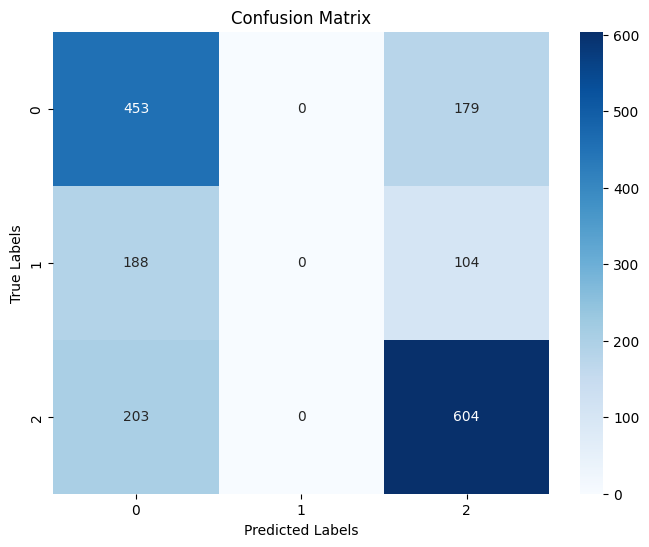

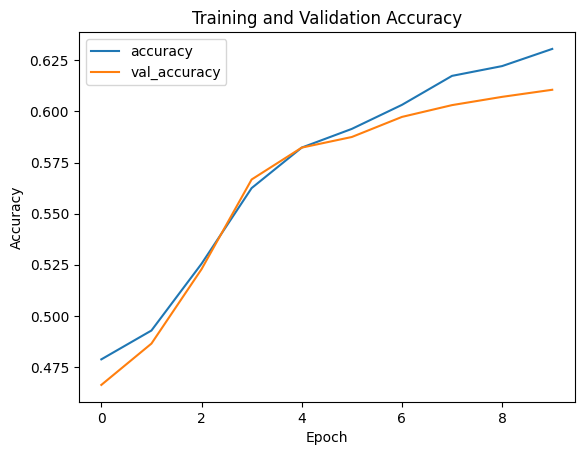

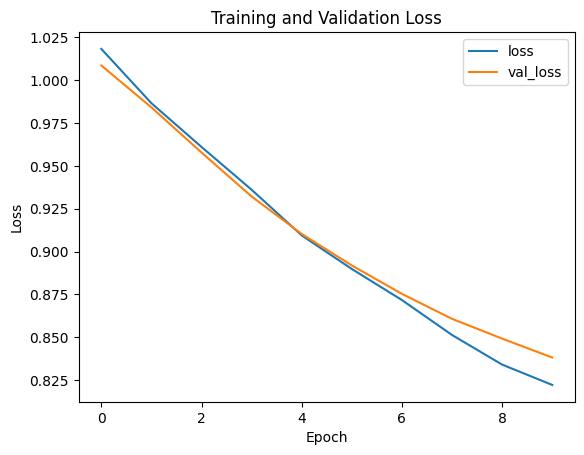

Fold 2
Epoch 1/10
187/187 [==============================] - 2s 10ms/step - loss: 0.8063 - accuracy: 0.6371 - val_loss: 0.8284 - val_accuracy: 0.6147
Epoch 2/10
187/187 [==============================] - 2s 10ms/step - loss: 0.7968 - accuracy: 0.6435 - val_loss: 0.8214 - val_accuracy: 0.6205
Epoch 3/10
187/187 [==============================] - 2s 11ms/step - loss: 0.7845 - accuracy: 0.6465 - val_loss: 0.8134 - val_accuracy: 0.6233
Epoch 4/10
187/187 [==============================] - 2s 12ms/step - loss: 0.7738 - accuracy: 0.6558 - val_loss: 0.8079 - val_accuracy: 0.6280
Epoch 5/10
187/187 [==============================] - 2s 11ms/step - loss: 0.7636 - accuracy: 0.6635 - val_loss: 0.8038 - val_accuracy: 0.6274
Epoch 6/10
187/187 [==============================] - 2s 10ms/step - loss: 0.7517 - accuracy: 0.6692 - val_loss: 0.7966 - val_accuracy: 0.6378
Epoch 7/10
187/187 [==============================] - 2s 11ms/step - loss: 0.7440 - accuracy: 0.6756 - val_loss: 0.7940 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



55/55 [==============================] - 0s 2ms/step
Validation Accuracy: 0.6418255343731947, Validation F1 Score: 0.603061021184101


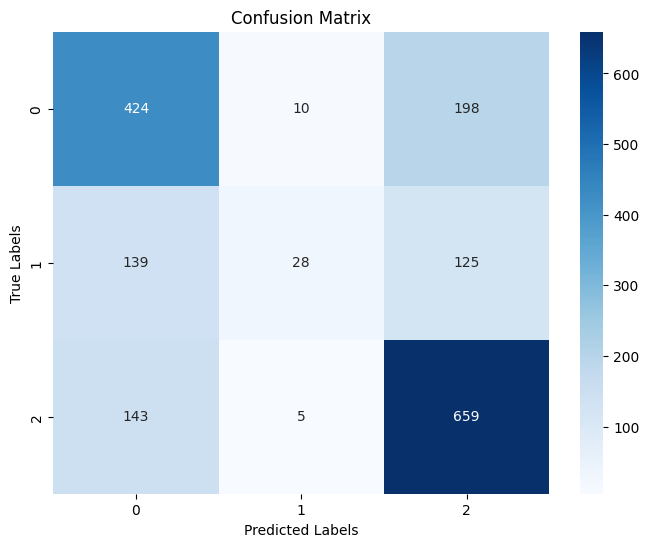

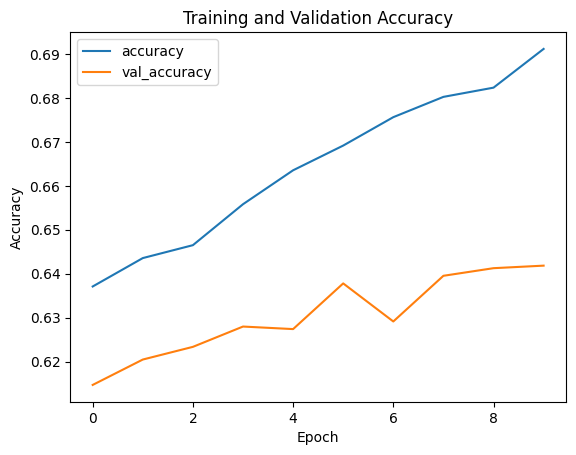

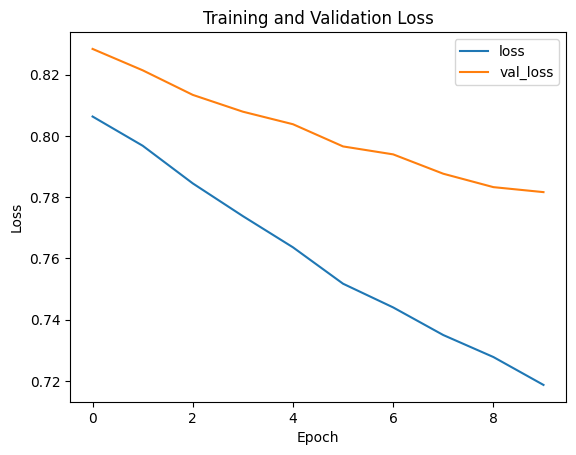

Fold 3
Epoch 1/10
187/187 [==============================] - 2s 11ms/step - loss: 0.7113 - accuracy: 0.6935 - val_loss: 0.7759 - val_accuracy: 0.6395
Epoch 2/10
187/187 [==============================] - 2s 10ms/step - loss: 0.7033 - accuracy: 0.6979 - val_loss: 0.7734 - val_accuracy: 0.6482
Epoch 3/10
187/187 [==============================] - 2s 11ms/step - loss: 0.6938 - accuracy: 0.7036 - val_loss: 0.7705 - val_accuracy: 0.6453
Epoch 4/10
187/187 [==============================] - 2s 13ms/step - loss: 0.6873 - accuracy: 0.7040 - val_loss: 0.7670 - val_accuracy: 0.6505
Epoch 5/10
187/187 [==============================] - 2s 10ms/step - loss: 0.6816 - accuracy: 0.7085 - val_loss: 0.7645 - val_accuracy: 0.6568
Epoch 6/10
187/187 [==============================] - 2s 10ms/step - loss: 0.6745 - accuracy: 0.7128 - val_loss: 0.7622 - val_accuracy: 0.6557
Epoch 7/10
187/187 [==============================] - 2s 10ms/step - loss: 0.6685 - accuracy: 0.7181 - val_loss: 0.7627 - val_accuracy:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from graphviz import Digraph
from keras.preprocessing.sequence import pad_sequences

# Define your create_model function with learning_rate as an argument
def create_model():
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len,
                                weights=[embedding_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(128, 3, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dropout_layer = Dropout(0.5)(pooling_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Function to train and evaluate model for each fold
def train_and_evaluate_model(X_train, y_train, X_val, y_val, fold, previous_model=None):
    if previous_model is None:
        model = create_model()
    else:
        model = previous_model

    # Train model
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=64, validation_data=(X_val, y_val))
    model.save(f"model_fold{fold}.h5")

    # Evaluate model
    y_pred = np.argmax(model.predict(X_val), axis=1)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='weighted')
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    print(f"Validation Accuracy: {accuracy}, Validation F1 Score: {f1}")

    # Plot confusion matrix
    plot_confusion_matrix(y_val, y_pred, labels=[0, 1, 2])

    # Plot training history
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

    return model  # Return the trained model

# Main program
num_epochs_list = [10, 20, 50]  # Different numbers of epochs to try
test_size_list = [0.15, 0.2, 0.25]    # Different test sizes to try
val_size_list = [0.15, 0.2, 0.25]      # Different validation sizes to try

for num_epochs in num_epochs_list:
    for test_size in test_size_list:
        for val_size in val_size_list:
            print(f"Number of Epochs: {num_epochs}, Test Size: {test_size}, Validation Size: {val_size}")
            accuracy_scores = []
            f1_scores = []
            precisions = []
            recalls = []
            kfold = KFold(n_splits=8, shuffle=True, random_state=42)
            # Iterate over each fold
            final_models = []  # List to store final models for each fold
            previous_model = None
            for fold, (train_indices, val_indices) in enumerate(kfold.split(text, y), 1):
                print(f'Fold {fold}')

                X_train, X_test, y_train, y_test = train_test_split(text, y, test_size=test_size, random_state=42)
                X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=val_size/(1-test_size), random_state=42)

                final_model = train_and_evaluate_model(X_train, y_train, X_val, y_val, fold, previous_model)
                final_models.append(final_model)  # Append the final model for this fold
                previous_model = final_model  # Set current model as previous model for next fold

            # Save final models for each fold
            for fold, model in enumerate(final_models, 1):
                model.save(f"final_model_variation_epochs_{num_epochs}_test_size_{test_size}_val_size_{val_size}_fold_{fold}.h5")

            # Print mean evaluation metrics across all folds
            print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
            print(f'Mean F1 Score: {np.mean(f1_scores)}')


Epochs: 10
Fold 1
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 1.4245 - accuracy: 0.5229 - val_loss: 0.8155 - val_accuracy: 0.6380
Epoch 2/10
223/223 [==============================] - 1s 6ms/step - loss: 0.8906 - accuracy: 0.6167 - val_loss: 0.7554 - val_accuracy: 0.6666
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.7666 - accuracy: 0.6678 - val_loss: 0.7392 - val_accuracy: 0.6781
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.7174 - accuracy: 0.6912 - val_loss: 0.7100 - val_accuracy: 0.6873
Epoch 5/10
223/223 [==============================] - 1s 7ms/step - loss: 0.6759 - accuracy: 0.7086 - val_loss: 0.7038 - val_accuracy: 0.6991
Epoch 6/10
223/223 [==============================] - 1s 7ms/step - loss: 0.6542 - accuracy: 0.7194 - val_loss: 0.6898 - val_accuracy: 0.7072
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.6318 - accuracy: 0.7315 - val_loss: 0.6796 - val_accur

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7066741446999439, Validation F1 Score: 0.7023213904961291, Validation Precision: 0.7052376290057167, Validation Recall: 0.7066741446999439
              precision    recall  f1-score   support

    Positive       0.65      0.57      0.60       877
    Negative       0.72      0.82      0.76      1866
     Neutral       0.74      0.61      0.67       823

    accuracy                           0.71      3566
   macro avg       0.70      0.66      0.68      3566
weighted avg       0.71      0.71      0.70      3566



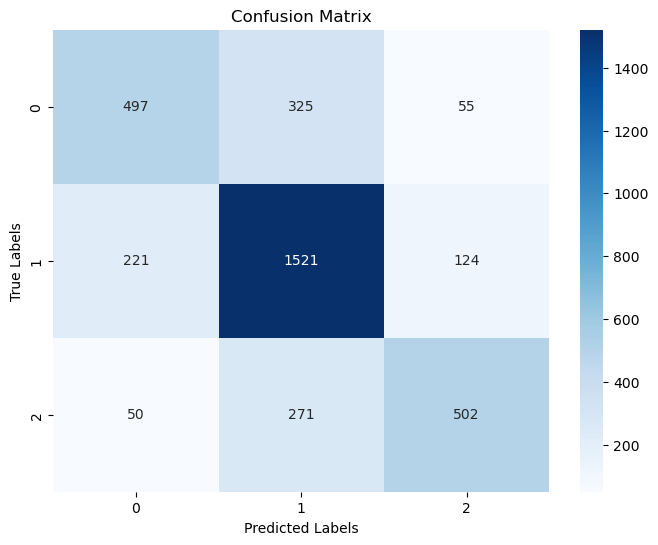

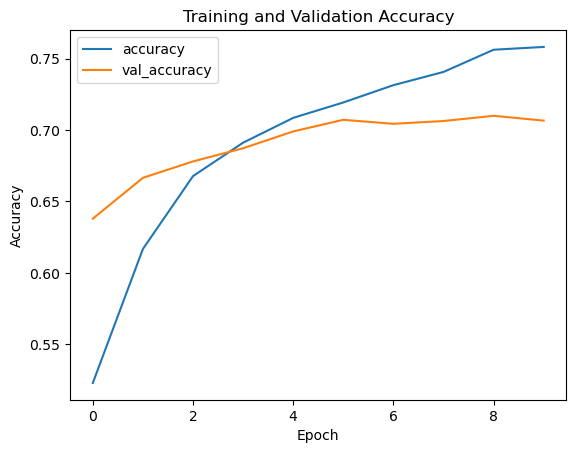

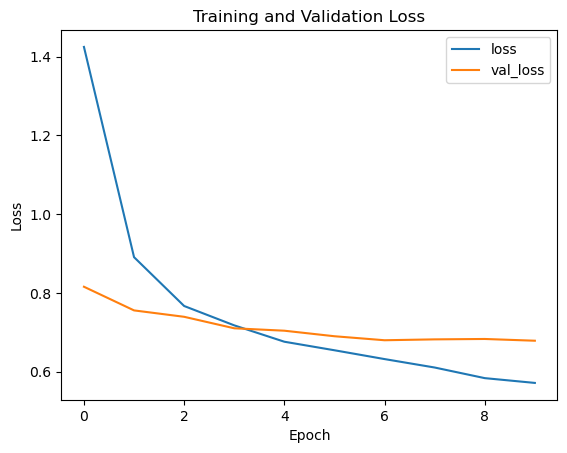

Fold 2
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.6092 - accuracy: 0.7447 - val_loss: 0.4853 - val_accuracy: 0.8057
Epoch 2/10
223/223 [==============================] - 1s 7ms/step - loss: 0.5736 - accuracy: 0.7589 - val_loss: 0.5254 - val_accuracy: 0.7737
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5625 - accuracy: 0.7660 - val_loss: 0.5148 - val_accuracy: 0.7841
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.5381 - accuracy: 0.7765 - val_loss: 0.5268 - val_accuracy: 0.7838
Epoch 5/10
223/223 [==============================] - 1s 7ms/step - loss: 0.5202 - accuracy: 0.7847 - val_loss: 0.5358 - val_accuracy: 0.7726
Epoch 6/10
223/223 [==============================] - 2s 7ms/step - loss: 0.5077 - accuracy: 0.7892 - val_loss: 0.5416 - val_accuracy: 0.7684
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4976 - accuracy: 0.7947 - val_loss: 0.5423 - val_accuracy: 0.7681

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7577117218171621, Validation F1 Score: 0.7544573264564403, Validation Precision: 0.7599132856983745, Validation Recall: 0.7577117218171621
              precision    recall  f1-score   support

    Positive       0.75      0.63      0.68       920
    Negative       0.74      0.86      0.80      1761
     Neutral       0.80      0.69      0.75       885

    accuracy                           0.76      3566
   macro avg       0.77      0.73      0.74      3566
weighted avg       0.76      0.76      0.75      3566



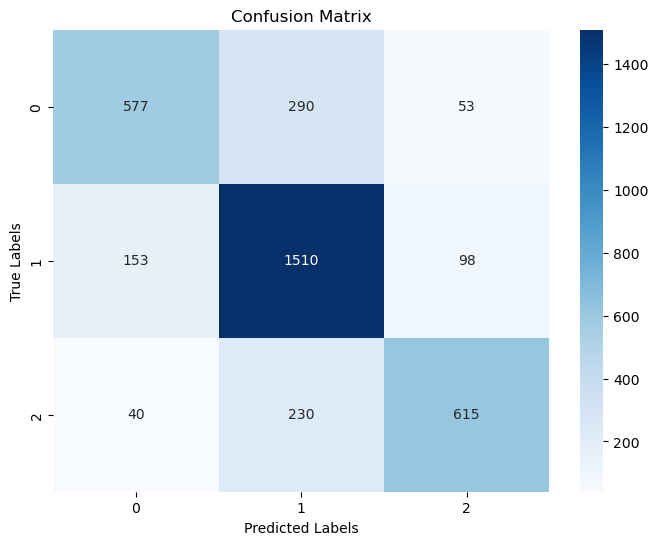

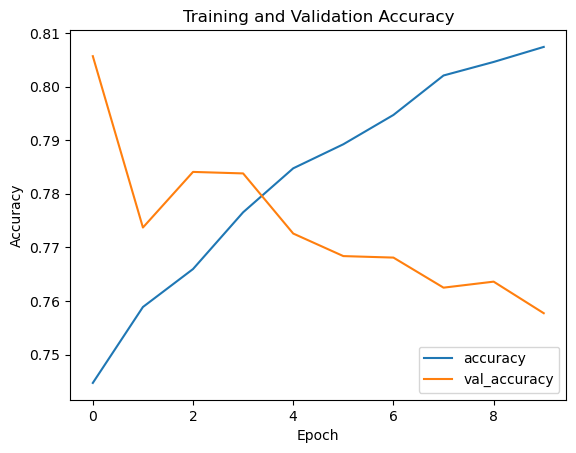

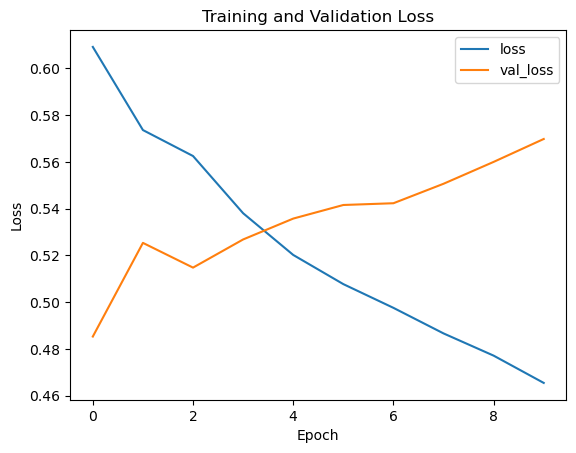

Fold 3
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.5286 - accuracy: 0.7820 - val_loss: 0.3524 - val_accuracy: 0.8808
Epoch 2/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4944 - accuracy: 0.7953 - val_loss: 0.3692 - val_accuracy: 0.8547
Epoch 3/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4698 - accuracy: 0.8068 - val_loss: 0.3854 - val_accuracy: 0.8438
Epoch 4/10
223/223 [==============================] - 1s 7ms/step - loss: 0.4574 - accuracy: 0.8150 - val_loss: 0.3940 - val_accuracy: 0.8508
Epoch 5/10
223/223 [==============================] - 1s 7ms/step - loss: 0.4488 - accuracy: 0.8147 - val_loss: 0.4096 - val_accuracy: 0.8340
Epoch 6/10
223/223 [==============================] - 1s 7ms/step - loss: 0.4361 - accuracy: 0.8213 - val_loss: 0.4219 - val_accuracy: 0.8292
Epoch 7/10
223/223 [==============================] - 1s 7ms/step - loss: 0.4217 - accuracy: 0.8313 - val_loss: 0.4361 - val_accuracy: 0.8186

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8087492989343803, Validation F1 Score: 0.8068375794596377, Validation Precision: 0.8101201934536256, Validation Recall: 0.8087492989343803
              precision    recall  f1-score   support

    Positive       0.82      0.70      0.75       932
    Negative       0.80      0.88      0.84      1806
     Neutral       0.83      0.77      0.80       828

    accuracy                           0.81      3566
   macro avg       0.82      0.78      0.80      3566
weighted avg       0.81      0.81      0.81      3566



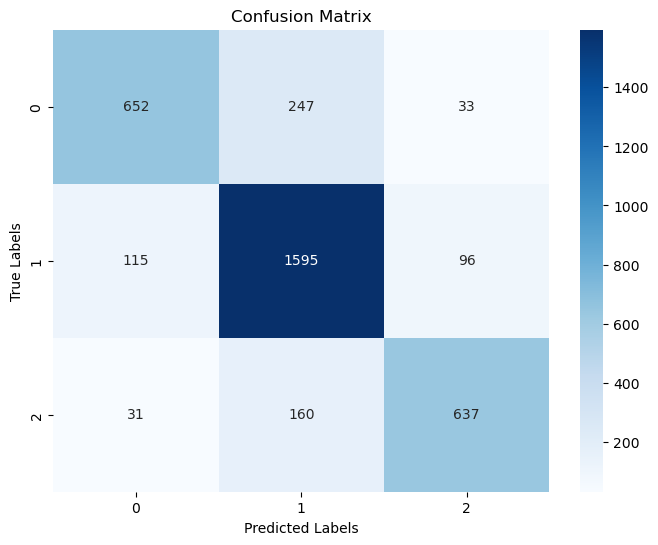

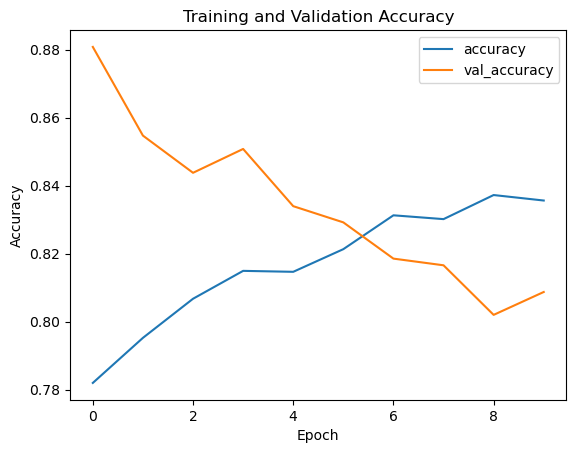

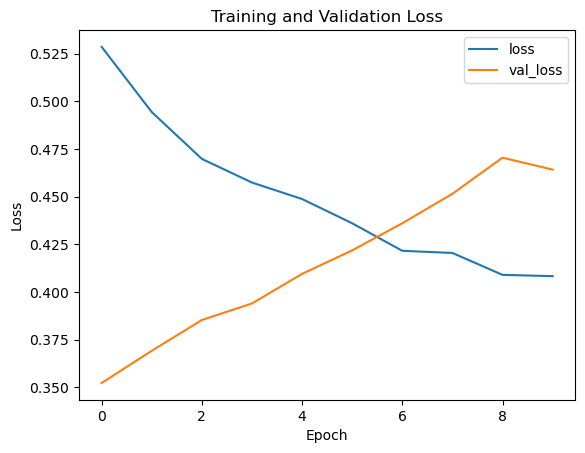

Fold 4
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4651 - accuracy: 0.8110 - val_loss: 0.2552 - val_accuracy: 0.9178
Epoch 2/10
223/223 [==============================] - 1s 7ms/step - loss: 0.4343 - accuracy: 0.8272 - val_loss: 0.2838 - val_accuracy: 0.8971
Epoch 3/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4077 - accuracy: 0.8336 - val_loss: 0.3004 - val_accuracy: 0.8830
Epoch 4/10
223/223 [==============================] - 1s 6ms/step - loss: 0.4039 - accuracy: 0.8411 - val_loss: 0.3098 - val_accuracy: 0.8853
Epoch 5/10
223/223 [==============================] - 1s 7ms/step - loss: 0.3955 - accuracy: 0.8432 - val_loss: 0.3234 - val_accuracy: 0.8769
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.3909 - accuracy: 0.8446 - val_loss: 0.3451 - val_accuracy: 0.8640
Epoch 7/10
223/223 [==============================] - 1s 7ms/step - loss: 0.3787 - accuracy: 0.8461 - val_loss: 0.3661 - val_accuracy: 0.8463

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8389901823281908, Validation F1 Score: 0.8376242131592061, Validation Precision: 0.8397167264824388, Validation Recall: 0.8389901823281908
              precision    recall  f1-score   support

    Positive       0.84      0.73      0.78       898
    Negative       0.83      0.90      0.86      1814
     Neutral       0.87      0.82      0.84       853

    accuracy                           0.84      3565
   macro avg       0.84      0.82      0.83      3565
weighted avg       0.84      0.84      0.84      3565



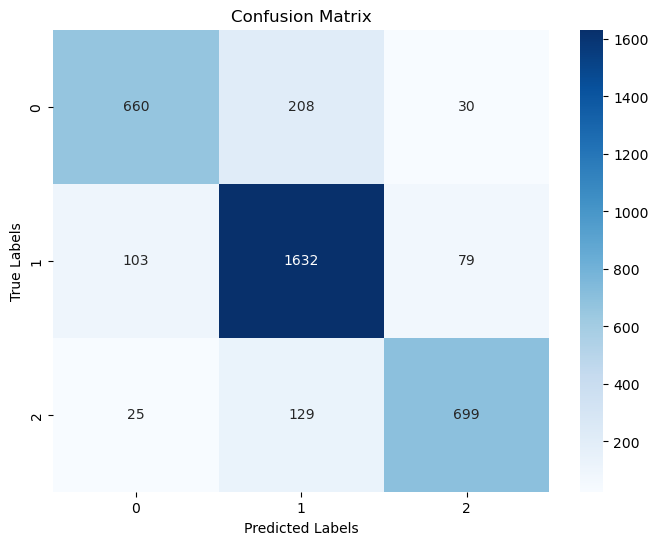

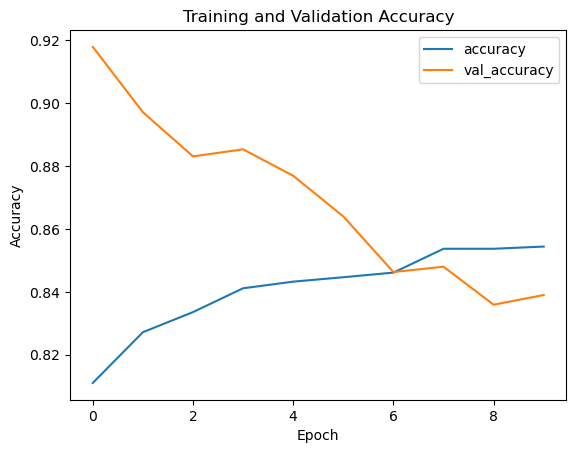

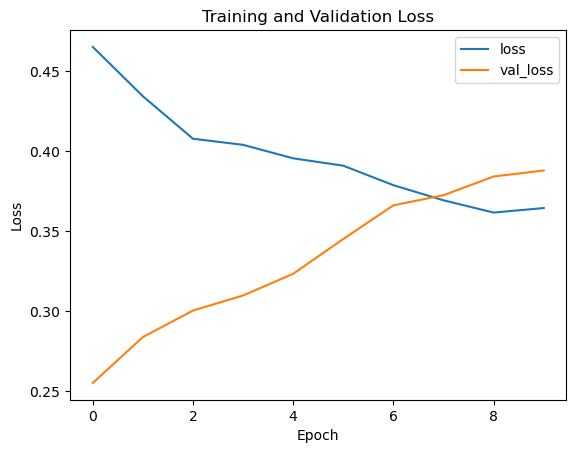

Fold 5
Epoch 1/10
223/223 [==============================] - 2s 7ms/step - loss: 0.4173 - accuracy: 0.8359 - val_loss: 0.2120 - val_accuracy: 0.9419
Epoch 2/10
223/223 [==============================] - 1s 7ms/step - loss: 0.3990 - accuracy: 0.8420 - val_loss: 0.2377 - val_accuracy: 0.9223
Epoch 3/10
223/223 [==============================] - 1s 7ms/step - loss: 0.3809 - accuracy: 0.8501 - val_loss: 0.2529 - val_accuracy: 0.9097
Epoch 4/10
223/223 [==============================] - 1s 7ms/step - loss: 0.3743 - accuracy: 0.8528 - val_loss: 0.2733 - val_accuracy: 0.9021
Epoch 5/10
223/223 [==============================] - 1s 7ms/step - loss: 0.3563 - accuracy: 0.8597 - val_loss: 0.2822 - val_accuracy: 0.8923
Epoch 6/10
223/223 [==============================] - 1s 6ms/step - loss: 0.3432 - accuracy: 0.8639 - val_loss: 0.2978 - val_accuracy: 0.8903
Epoch 7/10
223/223 [==============================] - 1s 6ms/step - loss: 0.3490 - accuracy: 0.8603 - val_loss: 0.3113 - val_accuracy: 0.8783

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8656381486676017, Validation F1 Score: 0.864965062025251, Validation Precision: 0.8665754375587158, Validation Recall: 0.8656381486676017
              precision    recall  f1-score   support

    Positive       0.86      0.80      0.83       926
    Negative       0.85      0.92      0.88      1800
     Neutral       0.90      0.83      0.86       839

    accuracy                           0.87      3565
   macro avg       0.87      0.85      0.86      3565
weighted avg       0.87      0.87      0.86      3565



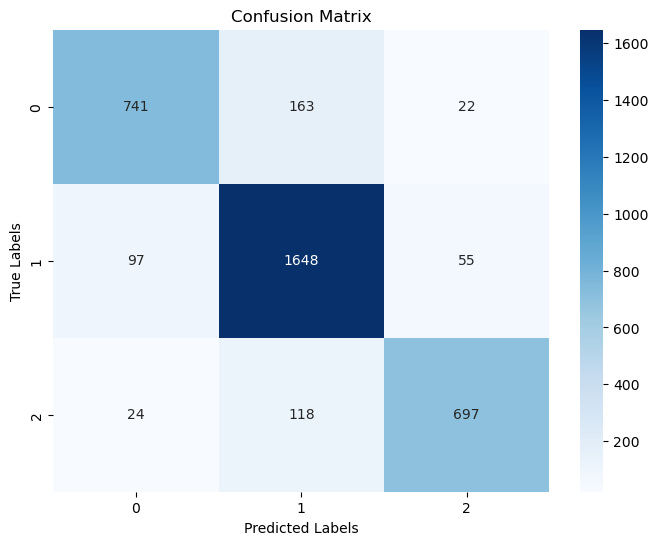

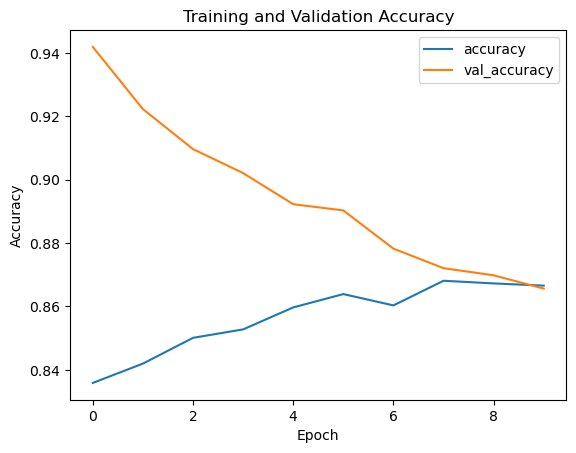

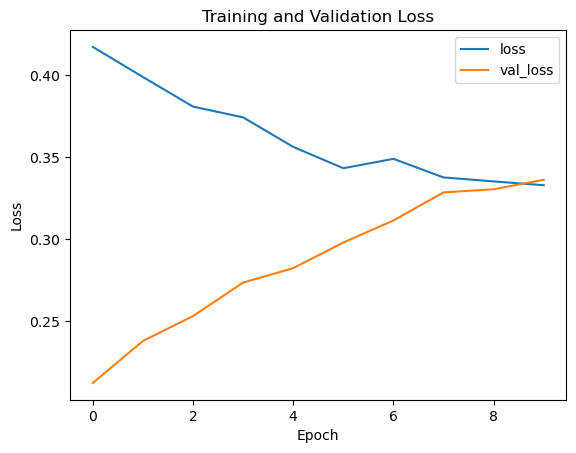

Mean Accuracy: 0.7955526992894557
Mean F1 Score: 0.7932411143193329

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.65      0.57      0.60       877
    Negative       0.72      0.82      0.76      1866
     Neutral       0.74      0.61      0.67       823

    accuracy                           0.71      3566
   macro avg       0.70      0.66      0.68      3566
weighted avg       0.71      0.71      0.70      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.75      0.63      0.68       920
    Negative       0.74      0.86      0.80      1761
     Neutral       0.80      0.69      0.75       885

    accuracy                           0.76      3566
   macro avg       0.77      0.73      0.74      3566
weighted avg       0.76      0.76      0.75      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7128435221536736, Validation F1 Score: 0.7075981536571629, Validation Precision: 0.710757947389072, Validation Recall: 0.7128435221536736
              precision    recall  f1-score   support

    Positive       0.68      0.54      0.61       877
    Negative       0.72      0.82      0.77      1866
     Neutral       0.72      0.64      0.68       823

    accuracy                           0.71      3566
   macro avg       0.71      0.67      0.68      3566
weighted avg       0.71      0.71      0.71      3566



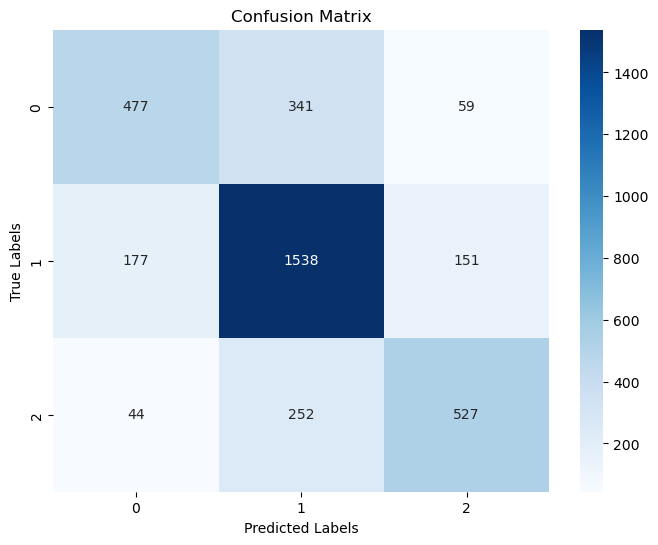

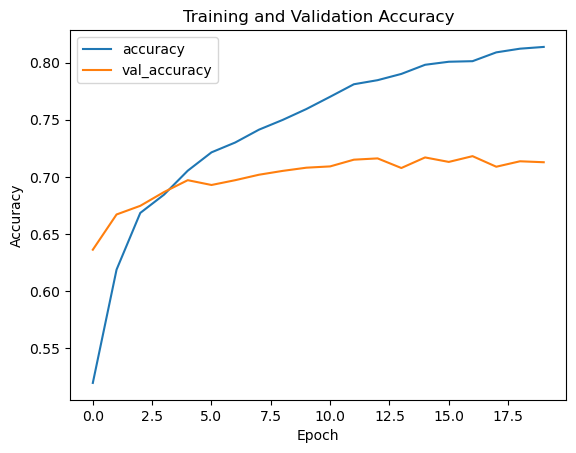

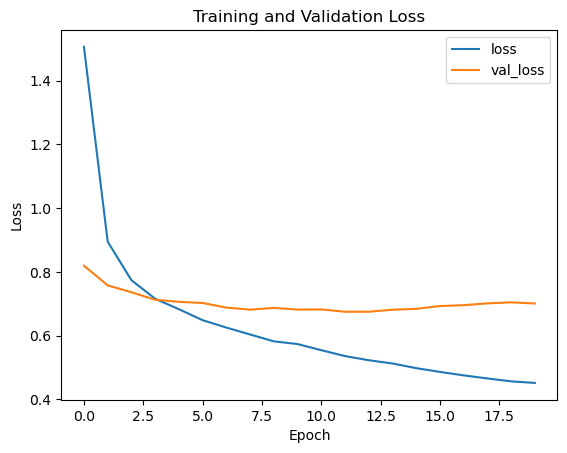

Fold 2
Epoch 1/20
223/223 [==============================] - 2s 7ms/step - loss: 0.5443 - accuracy: 0.7817 - val_loss: 0.3474 - val_accuracy: 0.8811
Epoch 2/20
223/223 [==============================] - 2s 7ms/step - loss: 0.5017 - accuracy: 0.7968 - val_loss: 0.3798 - val_accuracy: 0.8584
Epoch 3/20
223/223 [==============================] - 1s 7ms/step - loss: 0.4836 - accuracy: 0.8002 - val_loss: 0.4110 - val_accuracy: 0.8270
Epoch 4/20
223/223 [==============================] - 2s 7ms/step - loss: 0.4712 - accuracy: 0.8138 - val_loss: 0.4171 - val_accuracy: 0.8329
Epoch 5/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4586 - accuracy: 0.8131 - val_loss: 0.4263 - val_accuracy: 0.8256
Epoch 6/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4438 - accuracy: 0.8214 - val_loss: 0.4357 - val_accuracy: 0.8309
Epoch 7/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4372 - accuracy: 0.8241 - val_loss: 0.4579 - val_accuracy: 0.8054

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7750981491867639, Validation F1 Score: 0.7726203754391158, Validation Precision: 0.7797821480584837, Validation Recall: 0.7750981491867639
              precision    recall  f1-score   support

    Positive       0.76      0.67      0.71       920
    Negative       0.75      0.87      0.81      1761
     Neutral       0.85      0.70      0.77       885

    accuracy                           0.78      3566
   macro avg       0.79      0.75      0.76      3566
weighted avg       0.78      0.78      0.77      3566



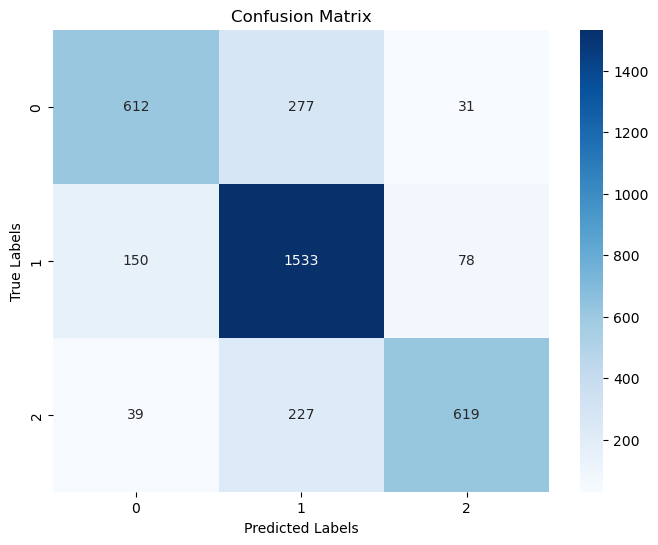

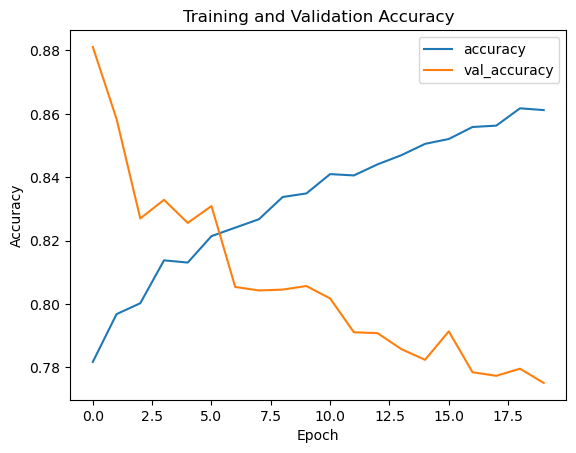

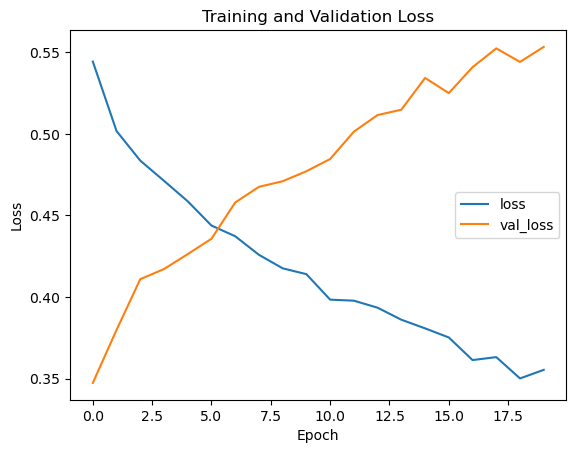

Fold 3
Epoch 1/20
223/223 [==============================] - 3s 12ms/step - loss: 0.4481 - accuracy: 0.8247 - val_loss: 0.2185 - val_accuracy: 0.9352
Epoch 2/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4230 - accuracy: 0.8294 - val_loss: 0.2421 - val_accuracy: 0.9285
Epoch 3/20
223/223 [==============================] - 2s 8ms/step - loss: 0.4023 - accuracy: 0.8406 - val_loss: 0.2632 - val_accuracy: 0.9133
Epoch 4/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3814 - accuracy: 0.8471 - val_loss: 0.2745 - val_accuracy: 0.9004
Epoch 5/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3748 - accuracy: 0.8516 - val_loss: 0.2882 - val_accuracy: 0.8940
Epoch 6/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3628 - accuracy: 0.8582 - val_loss: 0.3090 - val_accuracy: 0.8794
Epoch 7/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3588 - accuracy: 0.8585 - val_loss: 0.3232 - val_accuracy: 0.869

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8238923163208076, Validation F1 Score: 0.8220485490293822, Validation Precision: 0.8249889835750847, Validation Recall: 0.8238923163208076
              precision    recall  f1-score   support

    Positive       0.82      0.72      0.76       932
    Negative       0.81      0.90      0.85      1806
     Neutral       0.86      0.78      0.82       828

    accuracy                           0.82      3566
   macro avg       0.83      0.80      0.81      3566
weighted avg       0.82      0.82      0.82      3566



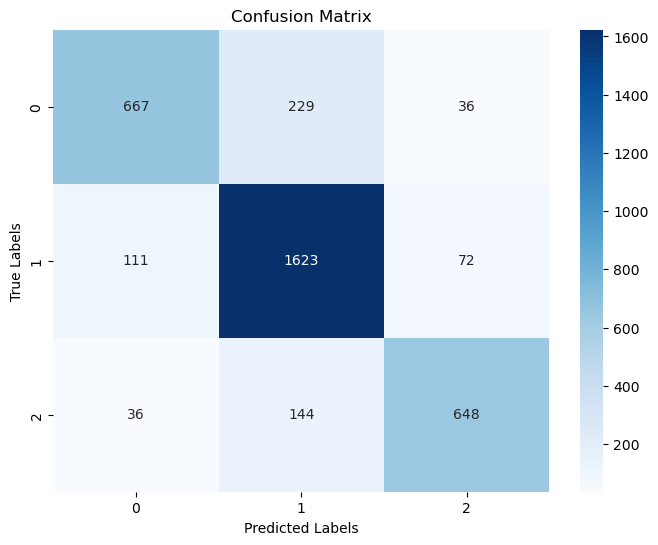

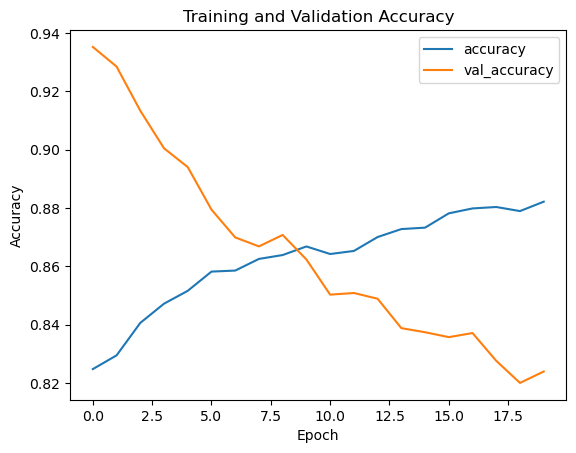

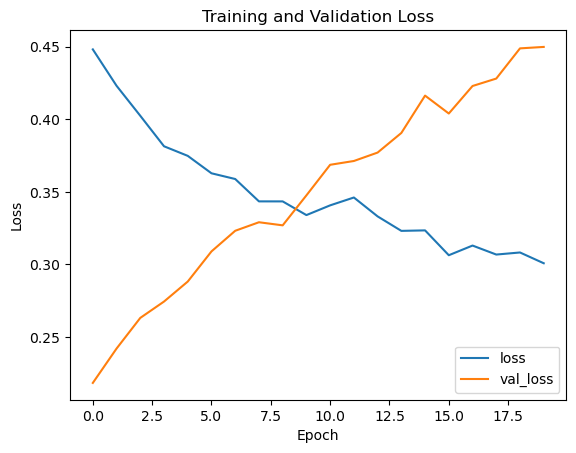

Fold 4
Epoch 1/20
223/223 [==============================] - 3s 9ms/step - loss: 0.4076 - accuracy: 0.8448 - val_loss: 0.1583 - val_accuracy: 0.9548
Epoch 2/20
223/223 [==============================] - 2s 8ms/step - loss: 0.3650 - accuracy: 0.8587 - val_loss: 0.1773 - val_accuracy: 0.9450
Epoch 3/20
223/223 [==============================] - 2s 8ms/step - loss: 0.3603 - accuracy: 0.8599 - val_loss: 0.1875 - val_accuracy: 0.9422
Epoch 4/20
223/223 [==============================] - 2s 8ms/step - loss: 0.3347 - accuracy: 0.8690 - val_loss: 0.2022 - val_accuracy: 0.9358
Epoch 5/20
223/223 [==============================] - 2s 8ms/step - loss: 0.3274 - accuracy: 0.8742 - val_loss: 0.2107 - val_accuracy: 0.9282
Epoch 6/20
223/223 [==============================] - 2s 8ms/step - loss: 0.3228 - accuracy: 0.8722 - val_loss: 0.2227 - val_accuracy: 0.9226
Epoch 7/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3215 - accuracy: 0.8757 - val_loss: 0.2368 - val_accuracy: 0.9130

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8516129032258064, Validation F1 Score: 0.8497724355289399, Validation Precision: 0.8543957453597175, Validation Recall: 0.8516129032258064
              precision    recall  f1-score   support

    Positive       0.87      0.73      0.79       898
    Negative       0.83      0.93      0.87      1814
     Neutral       0.89      0.83      0.86       853

    accuracy                           0.85      3565
   macro avg       0.86      0.83      0.84      3565
weighted avg       0.85      0.85      0.85      3565



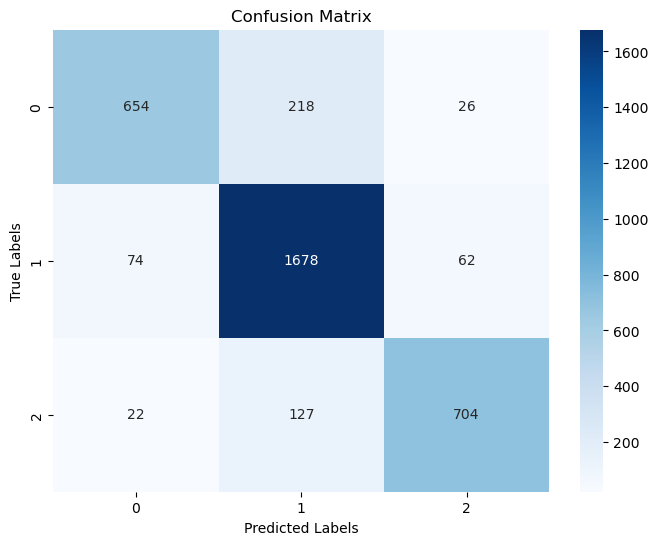

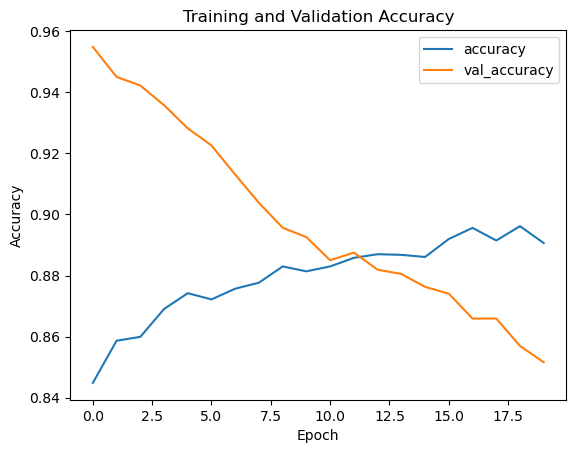

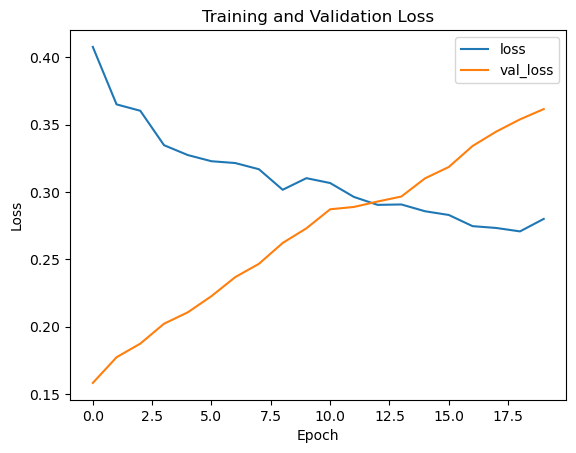

Fold 5
Epoch 1/20
223/223 [==============================] - 2s 8ms/step - loss: 0.3487 - accuracy: 0.8707 - val_loss: 0.1207 - val_accuracy: 0.9691
Epoch 2/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3240 - accuracy: 0.8723 - val_loss: 0.1445 - val_accuracy: 0.9627
Epoch 3/20
223/223 [==============================] - 2s 7ms/step - loss: 0.3090 - accuracy: 0.8793 - val_loss: 0.1578 - val_accuracy: 0.9529
Epoch 4/20
223/223 [==============================] - 1s 7ms/step - loss: 0.3077 - accuracy: 0.8788 - val_loss: 0.1701 - val_accuracy: 0.9487
Epoch 5/20
223/223 [==============================] - 1s 7ms/step - loss: 0.2855 - accuracy: 0.8895 - val_loss: 0.1704 - val_accuracy: 0.9425
Epoch 6/20
223/223 [==============================] - 1s 7ms/step - loss: 0.2797 - accuracy: 0.8906 - val_loss: 0.1833 - val_accuracy: 0.9366
Epoch 7/20
223/223 [==============================] - 2s 7ms/step - loss: 0.2783 - accuracy: 0.8920 - val_loss: 0.1988 - val_accuracy: 0.9307

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8754558204768583, Validation F1 Score: 0.874629466338893, Validation Precision: 0.8777993908851334, Validation Recall: 0.8754558204768583
              precision    recall  f1-score   support

    Positive       0.91      0.79      0.85       926
    Negative       0.85      0.93      0.89      1800
     Neutral       0.89      0.85      0.87       839

    accuracy                           0.88      3565
   macro avg       0.89      0.86      0.87      3565
weighted avg       0.88      0.88      0.87      3565



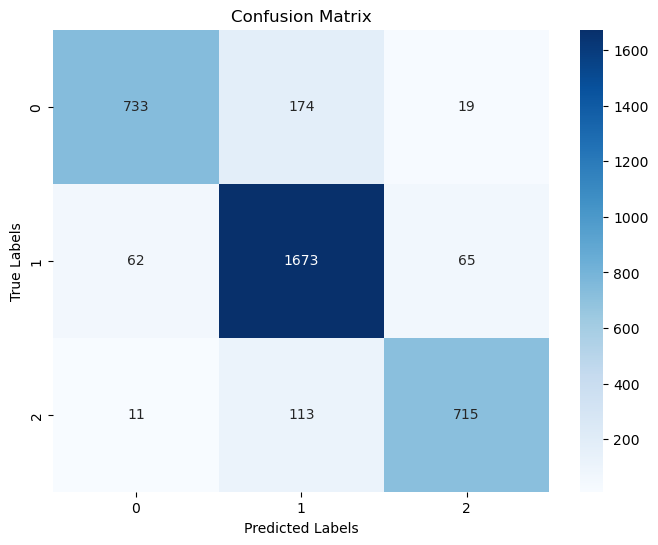

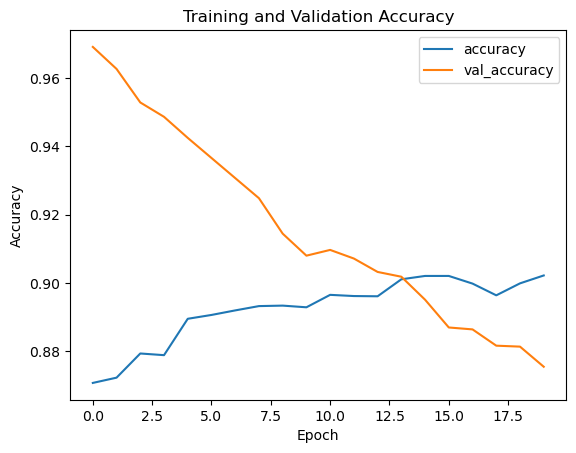

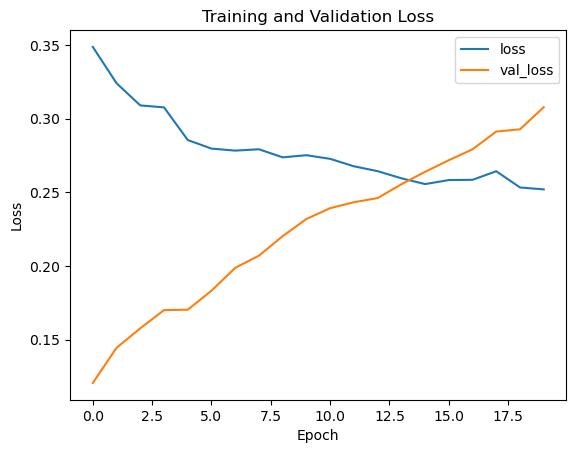

Mean Accuracy: 0.8077805422727821
Mean F1 Score: 0.8053337959986987

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.68      0.54      0.61       877
    Negative       0.72      0.82      0.77      1866
     Neutral       0.72      0.64      0.68       823

    accuracy                           0.71      3566
   macro avg       0.71      0.67      0.68      3566
weighted avg       0.71      0.71      0.71      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.76      0.67      0.71       920
    Negative       0.75      0.87      0.81      1761
     Neutral       0.85      0.70      0.77       885

    accuracy                           0.78      3566
   macro avg       0.79      0.75      0.76      3566
weighted avg       0.78      0.78      0.77      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7153673583847449, Validation F1 Score: 0.7119753895295163, Validation Precision: 0.7130176208713801, Validation Recall: 0.7153673583847449
              precision    recall  f1-score   support

    Positive       0.67      0.58      0.62       877
    Negative       0.73      0.81      0.77      1866
     Neutral       0.72      0.64      0.68       823

    accuracy                           0.72      3566
   macro avg       0.71      0.68      0.69      3566
weighted avg       0.71      0.72      0.71      3566



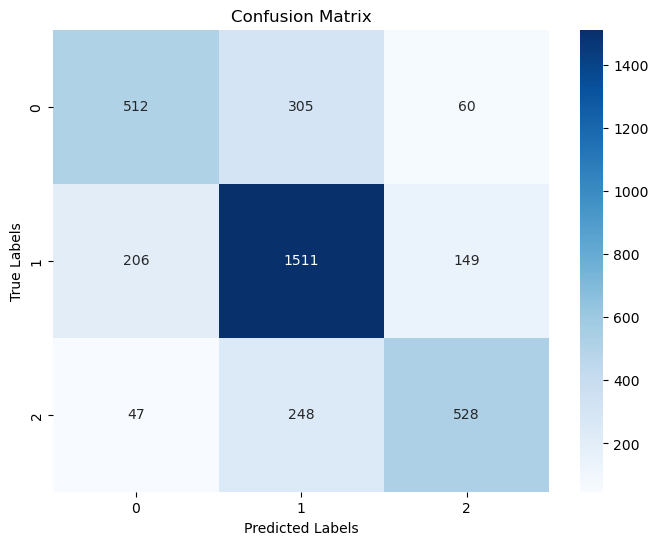

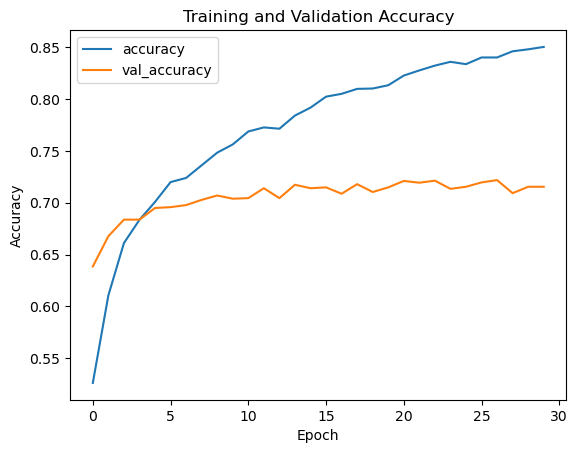

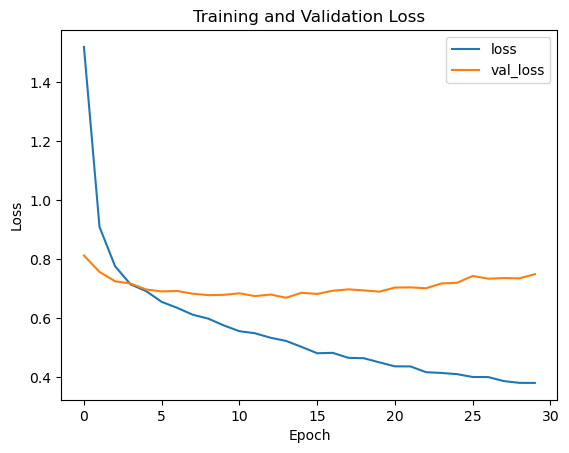

Fold 2
Epoch 1/30
223/223 [==============================] - 2s 8ms/step - loss: 0.5125 - accuracy: 0.8075 - val_loss: 0.2852 - val_accuracy: 0.9007
Epoch 2/30
223/223 [==============================] - 1s 7ms/step - loss: 0.4693 - accuracy: 0.8170 - val_loss: 0.2979 - val_accuracy: 0.8968
Epoch 3/30
223/223 [==============================] - 2s 7ms/step - loss: 0.4355 - accuracy: 0.8274 - val_loss: 0.3294 - val_accuracy: 0.8713
Epoch 4/30
223/223 [==============================] - 1s 7ms/step - loss: 0.4250 - accuracy: 0.8322 - val_loss: 0.3394 - val_accuracy: 0.8738
Epoch 5/30
223/223 [==============================] - 1s 7ms/step - loss: 0.4152 - accuracy: 0.8354 - val_loss: 0.3559 - val_accuracy: 0.8592
Epoch 6/30
223/223 [==============================] - 1s 7ms/step - loss: 0.4060 - accuracy: 0.8427 - val_loss: 0.3681 - val_accuracy: 0.8489
Epoch 7/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3941 - accuracy: 0.8438 - val_loss: 0.3897 - val_accuracy: 0.8368

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7854739203589456, Validation F1 Score: 0.7832217345674234, Validation Precision: 0.7882250628520915, Validation Recall: 0.7854739203589456
              precision    recall  f1-score   support

    Positive       0.78      0.69      0.73       920
    Negative       0.77      0.87      0.82      1761
     Neutral       0.84      0.71      0.77       885

    accuracy                           0.79      3566
   macro avg       0.79      0.76      0.77      3566
weighted avg       0.79      0.79      0.78      3566



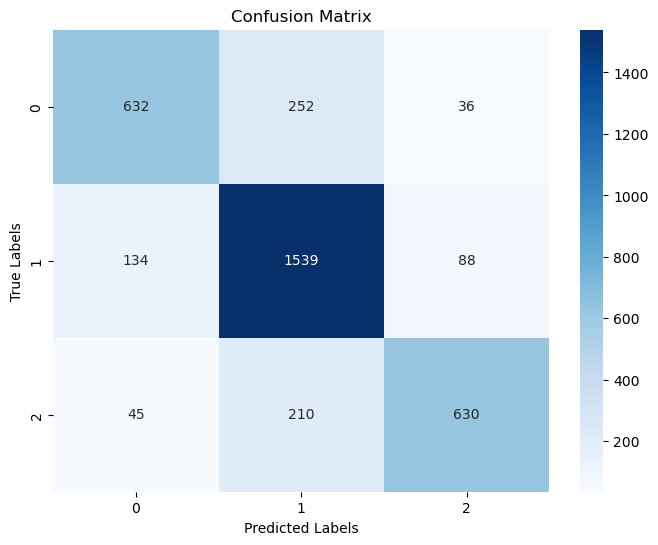

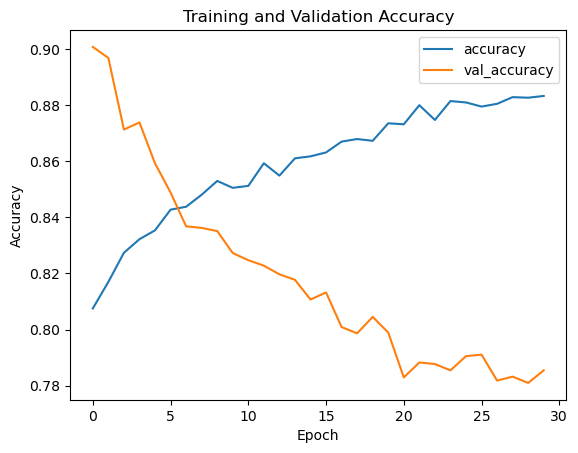

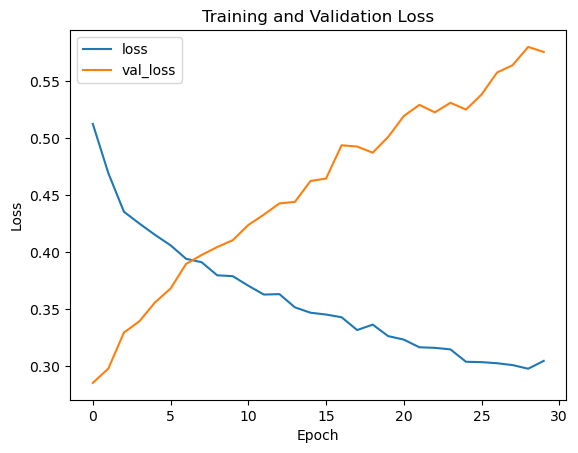

Fold 3
Epoch 1/30
223/223 [==============================] - 2s 8ms/step - loss: 0.4245 - accuracy: 0.8414 - val_loss: 0.1631 - val_accuracy: 0.9593
Epoch 2/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3883 - accuracy: 0.8536 - val_loss: 0.1887 - val_accuracy: 0.9459
Epoch 3/30
223/223 [==============================] - 2s 8ms/step - loss: 0.3570 - accuracy: 0.8619 - val_loss: 0.1988 - val_accuracy: 0.9391
Epoch 4/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3383 - accuracy: 0.8686 - val_loss: 0.2105 - val_accuracy: 0.9305
Epoch 5/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3455 - accuracy: 0.8659 - val_loss: 0.2287 - val_accuracy: 0.9215
Epoch 6/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3213 - accuracy: 0.8779 - val_loss: 0.2429 - val_accuracy: 0.9139
Epoch 7/30
223/223 [==============================] - 1s 7ms/step - loss: 0.3148 - accuracy: 0.8770 - val_loss: 0.2541 - val_accuracy: 0.9075

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8381940549635446, Validation F1 Score: 0.8373065726778943, Validation Precision: 0.8381712278405592, Validation Recall: 0.8381940549635446
              precision    recall  f1-score   support

    Positive       0.81      0.76      0.79       932
    Negative       0.84      0.89      0.87      1806
     Neutral       0.86      0.80      0.83       828

    accuracy                           0.84      3566
   macro avg       0.84      0.82      0.83      3566
weighted avg       0.84      0.84      0.84      3566



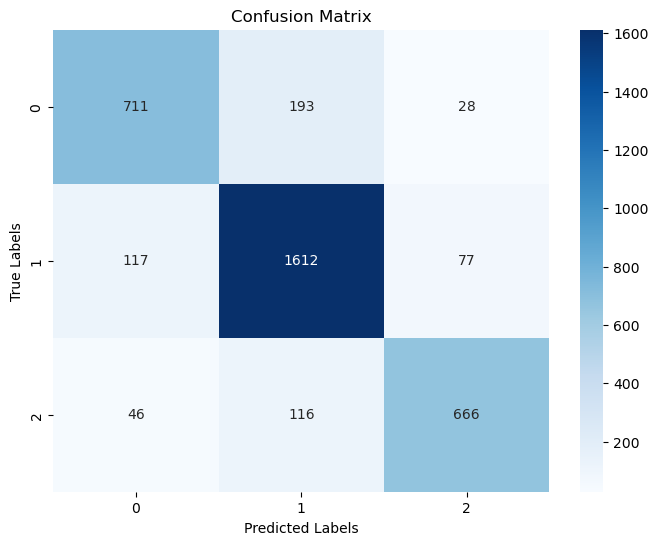

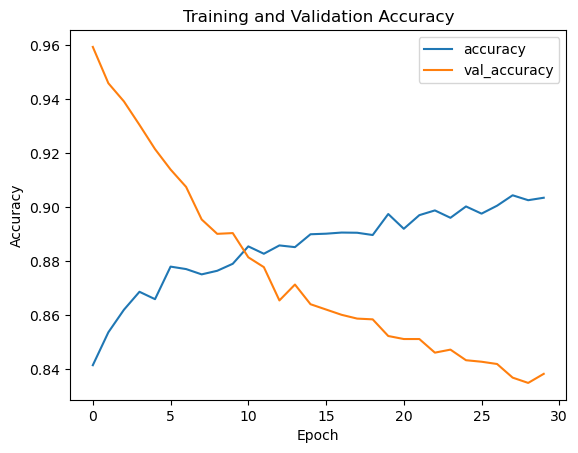

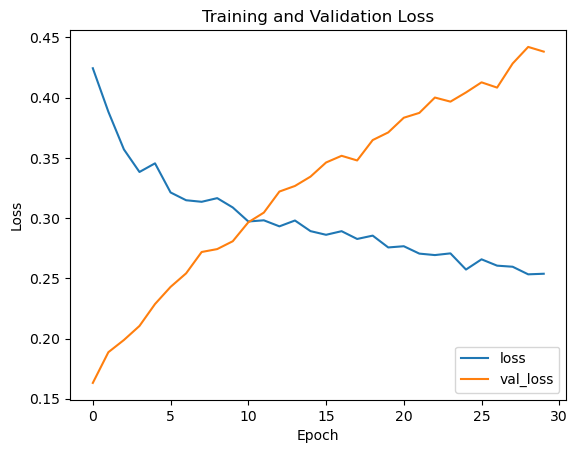

Fold 4
Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3819 - accuracy: 0.8645 - val_loss: 0.1201 - val_accuracy: 0.9697
Epoch 2/30
223/223 [==============================] - 2s 8ms/step - loss: 0.3286 - accuracy: 0.8739 - val_loss: 0.1311 - val_accuracy: 0.9635
Epoch 3/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3168 - accuracy: 0.8759 - val_loss: 0.1433 - val_accuracy: 0.9582
Epoch 4/30
223/223 [==============================] - 2s 9ms/step - loss: 0.3021 - accuracy: 0.8857 - val_loss: 0.1503 - val_accuracy: 0.9506
Epoch 5/30
223/223 [==============================] - 2s 8ms/step - loss: 0.2960 - accuracy: 0.8895 - val_loss: 0.1664 - val_accuracy: 0.9436
Epoch 6/30
223/223 [==============================] - 2s 8ms/step - loss: 0.2818 - accuracy: 0.8912 - val_loss: 0.1804 - val_accuracy: 0.9386
Epoch 7/30
223/223 [==============================] - 2s 9ms/step - loss: 0.2737 - accuracy: 0.8955 - val_loss: 0.1851 - val_accuracy: 0.9346

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8701262272089761, Validation F1 Score: 0.8687270331120996, Validation Precision: 0.8721241243042507, Validation Recall: 0.8701262272089761
              precision    recall  f1-score   support

    Positive       0.88      0.78      0.83       898
    Negative       0.85      0.94      0.89      1814
     Neutral       0.90      0.81      0.85       853

    accuracy                           0.87      3565
   macro avg       0.88      0.85      0.86      3565
weighted avg       0.87      0.87      0.87      3565



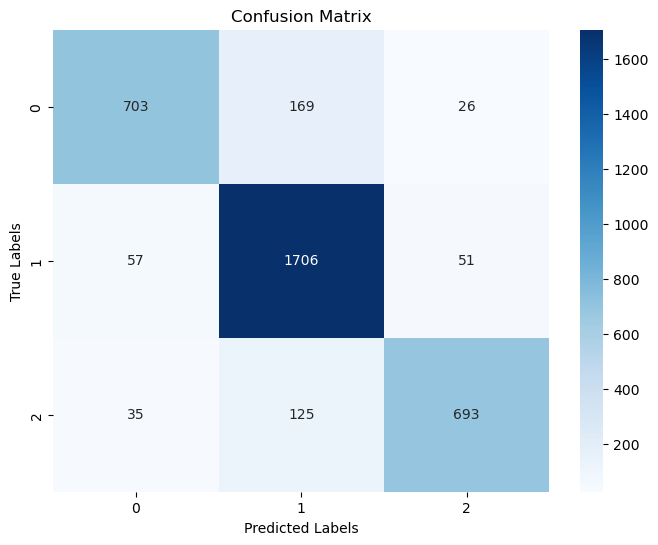

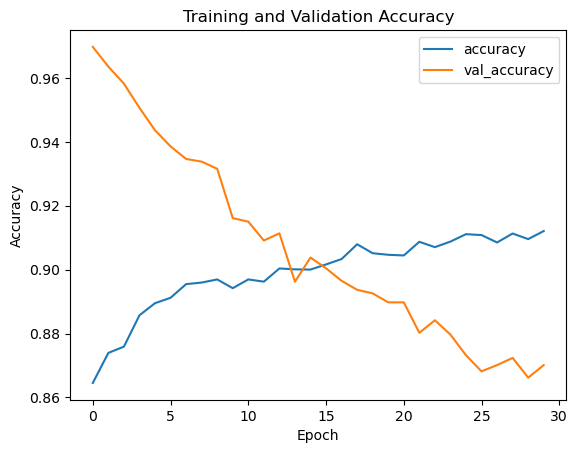

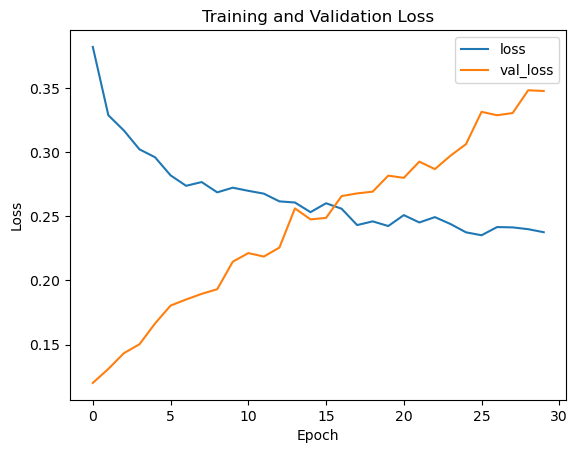

Fold 5
Epoch 1/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3491 - accuracy: 0.8767 - val_loss: 0.0972 - val_accuracy: 0.9795
Epoch 2/30
223/223 [==============================] - 2s 7ms/step - loss: 0.3052 - accuracy: 0.8871 - val_loss: 0.1105 - val_accuracy: 0.9683
Epoch 3/30
223/223 [==============================] - 1s 7ms/step - loss: 0.2922 - accuracy: 0.8907 - val_loss: 0.1181 - val_accuracy: 0.9680
Epoch 4/30
223/223 [==============================] - 1s 7ms/step - loss: 0.2738 - accuracy: 0.8969 - val_loss: 0.1243 - val_accuracy: 0.9663
Epoch 5/30
223/223 [==============================] - 2s 7ms/step - loss: 0.2683 - accuracy: 0.8962 - val_loss: 0.1311 - val_accuracy: 0.9593
Epoch 6/30
223/223 [==============================] - 1s 6ms/step - loss: 0.2507 - accuracy: 0.9064 - val_loss: 0.1426 - val_accuracy: 0.9506
Epoch 7/30
223/223 [==============================] - 1s 7ms/step - loss: 0.2521 - accuracy: 0.9037 - val_loss: 0.1511 - val_accuracy: 0.9445

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8810659186535764, Validation F1 Score: 0.88044947569732, Validation Precision: 0.8823343420434853, Validation Recall: 0.8810659186535764
              precision    recall  f1-score   support

    Positive       0.89      0.82      0.85       926
    Negative       0.87      0.93      0.90      1800
     Neutral       0.91      0.84      0.88       839

    accuracy                           0.88      3565
   macro avg       0.89      0.86      0.88      3565
weighted avg       0.88      0.88      0.88      3565



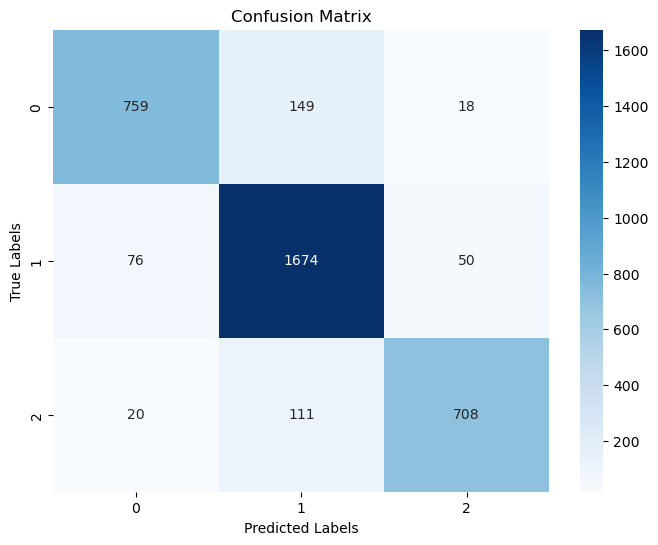

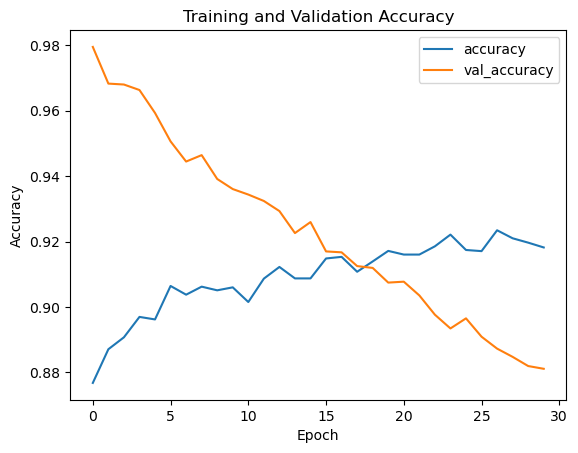

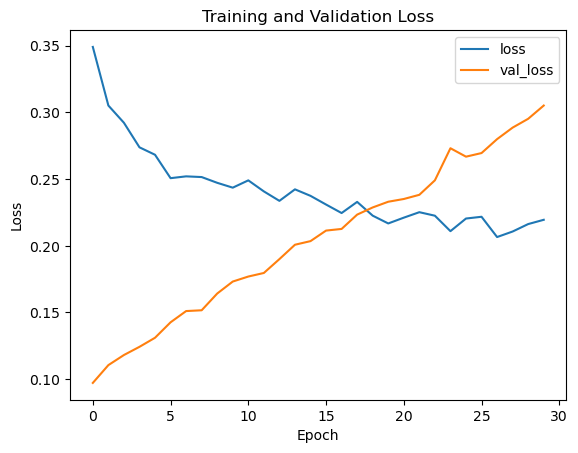

Mean Accuracy: 0.8180454959139576
Mean F1 Score: 0.8163360411168508

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.67      0.58      0.62       877
    Negative       0.73      0.81      0.77      1866
     Neutral       0.72      0.64      0.68       823

    accuracy                           0.72      3566
   macro avg       0.71      0.68      0.69      3566
weighted avg       0.71      0.72      0.71      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.78      0.69      0.73       920
    Negative       0.77      0.87      0.82      1761
     Neutral       0.84      0.71      0.77       885

    accuracy                           0.79      3566
   macro avg       0.79      0.76      0.77      3566
weighted avg       0.79      0.79      0.78      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7181716208637129, Validation F1 Score: 0.7150925159675018, Validation Precision: 0.7174228274976561, Validation Recall: 0.7181716208637129
              precision    recall  f1-score   support

    Positive       0.66      0.60      0.63       877
    Negative       0.73      0.81      0.77      1866
     Neutral       0.75      0.62      0.68       823

    accuracy                           0.72      3566
   macro avg       0.71      0.68      0.69      3566
weighted avg       0.72      0.72      0.72      3566



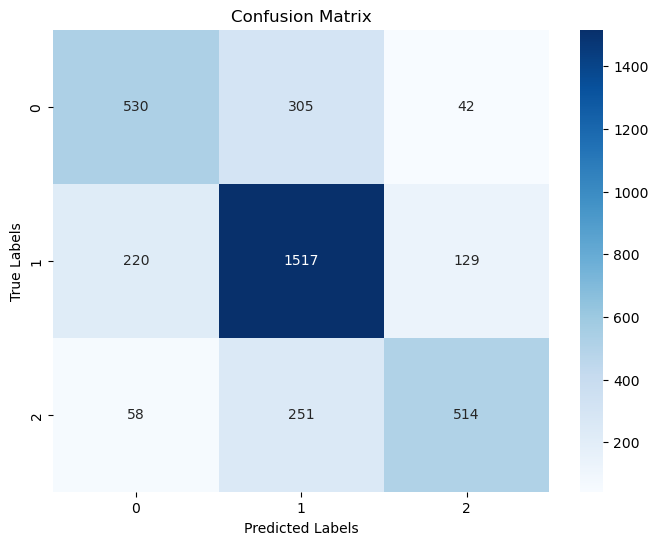

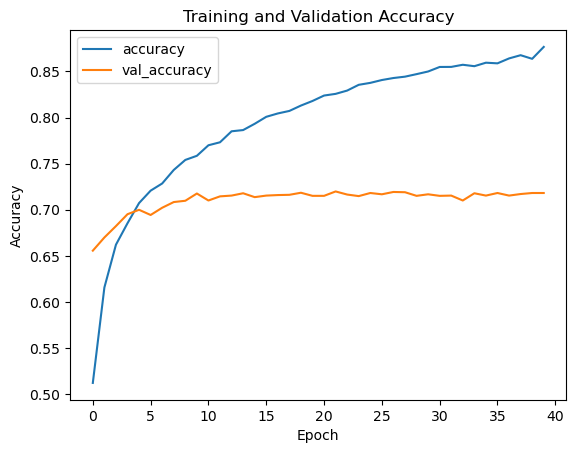

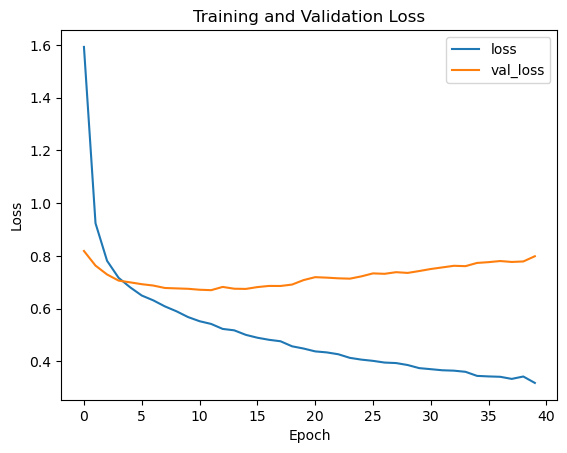

Fold 2
Epoch 1/40
223/223 [==============================] - 2s 8ms/step - loss: 0.5012 - accuracy: 0.8148 - val_loss: 0.2183 - val_accuracy: 0.9425
Epoch 2/40
223/223 [==============================] - 2s 7ms/step - loss: 0.4345 - accuracy: 0.8311 - val_loss: 0.2483 - val_accuracy: 0.9209
Epoch 3/40
223/223 [==============================] - 1s 7ms/step - loss: 0.4129 - accuracy: 0.8405 - val_loss: 0.2682 - val_accuracy: 0.9033
Epoch 4/40
223/223 [==============================] - 1s 7ms/step - loss: 0.3985 - accuracy: 0.8467 - val_loss: 0.2793 - val_accuracy: 0.8990
Epoch 5/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3804 - accuracy: 0.8525 - val_loss: 0.3030 - val_accuracy: 0.8839
Epoch 6/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3783 - accuracy: 0.8522 - val_loss: 0.3236 - val_accuracy: 0.8679
Epoch 7/40
223/223 [==============================] - 1s 6ms/step - loss: 0.3606 - accuracy: 0.8582 - val_loss: 0.3142 - val_accuracy: 0.8769

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7837913628715648, Validation F1 Score: 0.7825045272780733, Validation Precision: 0.7842380404904653, Validation Recall: 0.7837913628715648
              precision    recall  f1-score   support

    Positive       0.75      0.70      0.73       920
    Negative       0.78      0.85      0.82      1761
     Neutral       0.82      0.73      0.77       885

    accuracy                           0.78      3566
   macro avg       0.79      0.76      0.77      3566
weighted avg       0.78      0.78      0.78      3566



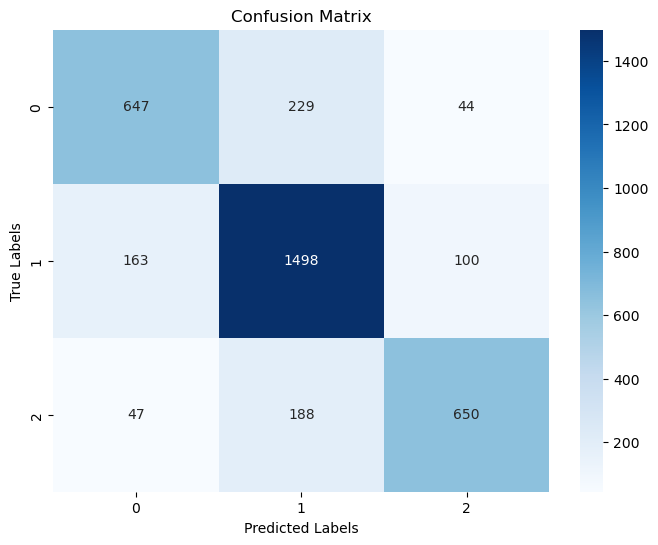

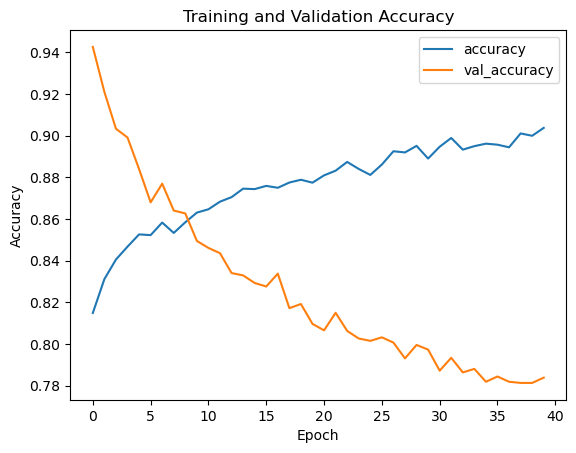

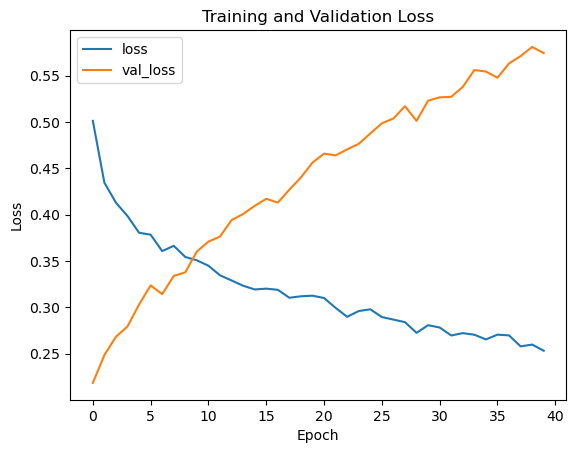

Fold 3
Epoch 1/40
223/223 [==============================] - 2s 7ms/step - loss: 0.4108 - accuracy: 0.8528 - val_loss: 0.1208 - val_accuracy: 0.9728
Epoch 2/40
223/223 [==============================] - 1s 7ms/step - loss: 0.3524 - accuracy: 0.8673 - val_loss: 0.1399 - val_accuracy: 0.9635
Epoch 3/40
223/223 [==============================] - 1s 6ms/step - loss: 0.3287 - accuracy: 0.8718 - val_loss: 0.1581 - val_accuracy: 0.9532
Epoch 4/40
223/223 [==============================] - 1s 7ms/step - loss: 0.3186 - accuracy: 0.8792 - val_loss: 0.1738 - val_accuracy: 0.9428
Epoch 5/40
223/223 [==============================] - 1s 7ms/step - loss: 0.3094 - accuracy: 0.8787 - val_loss: 0.1822 - val_accuracy: 0.9372
Epoch 6/40
223/223 [==============================] - 1s 7ms/step - loss: 0.2963 - accuracy: 0.8828 - val_loss: 0.1911 - val_accuracy: 0.9338
Epoch 7/40
223/223 [==============================] - 2s 7ms/step - loss: 0.3001 - accuracy: 0.8833 - val_loss: 0.2006 - val_accuracy: 0.9254

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8337072349971958, Validation F1 Score: 0.8322177449731755, Validation Precision: 0.8357525778028967, Validation Recall: 0.8337072349971958
              precision    recall  f1-score   support

    Positive       0.82      0.75      0.79       932
    Negative       0.82      0.91      0.86      1806
     Neutral       0.88      0.77      0.82       828

    accuracy                           0.83      3566
   macro avg       0.84      0.81      0.82      3566
weighted avg       0.84      0.83      0.83      3566



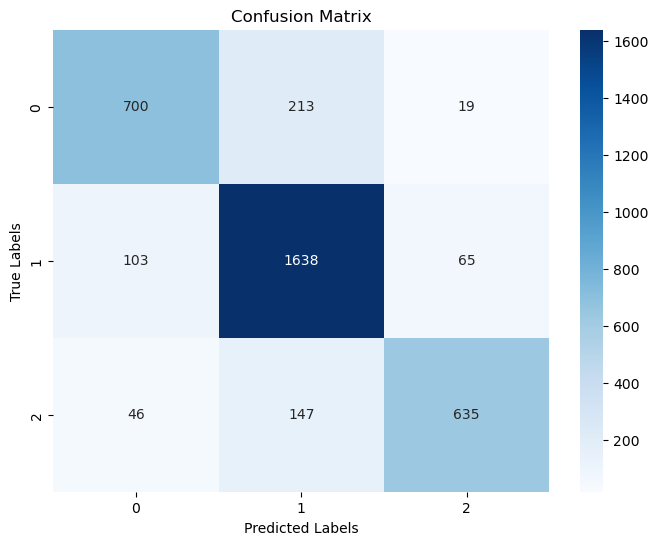

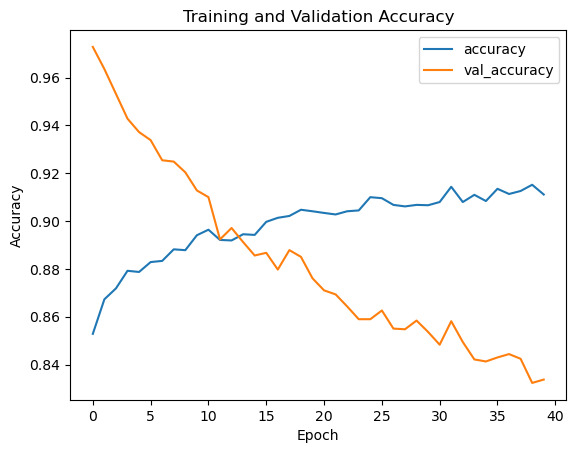

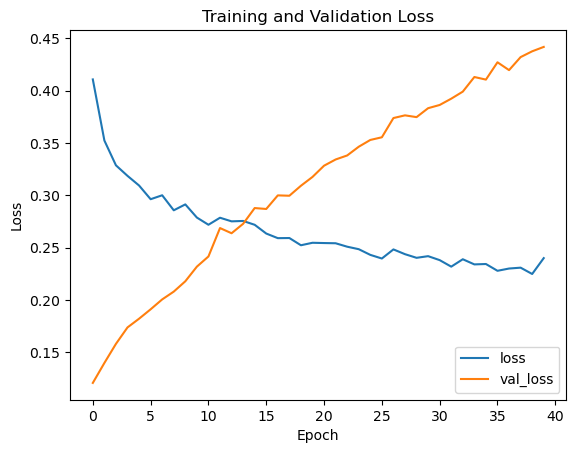

Fold 4
Epoch 1/40
223/223 [==============================] - 3s 10ms/step - loss: 0.3552 - accuracy: 0.8758 - val_loss: 0.0924 - val_accuracy: 0.9778
Epoch 2/40
223/223 [==============================] - 1s 7ms/step - loss: 0.3098 - accuracy: 0.8819 - val_loss: 0.1083 - val_accuracy: 0.9700
Epoch 3/40
223/223 [==============================] - 1s 7ms/step - loss: 0.2820 - accuracy: 0.8966 - val_loss: 0.1154 - val_accuracy: 0.9689
Epoch 4/40
223/223 [==============================] - 2s 7ms/step - loss: 0.2772 - accuracy: 0.8921 - val_loss: 0.1234 - val_accuracy: 0.9649
Epoch 5/40
223/223 [==============================] - 1s 6ms/step - loss: 0.2652 - accuracy: 0.8989 - val_loss: 0.1361 - val_accuracy: 0.9532
Epoch 6/40
223/223 [==============================] - 1s 7ms/step - loss: 0.2600 - accuracy: 0.9008 - val_loss: 0.1434 - val_accuracy: 0.9579
Epoch 7/40
223/223 [==============================] - 2s 7ms/step - loss: 0.2604 - accuracy: 0.9041 - val_loss: 0.1487 - val_accuracy: 0.950

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8687237026647966, Validation F1 Score: 0.8674596209208796, Validation Precision: 0.8707431923369835, Validation Recall: 0.8687237026647966
              precision    recall  f1-score   support

    Positive       0.89      0.77      0.82       898
    Negative       0.85      0.93      0.89      1814
     Neutral       0.90      0.83      0.87       853

    accuracy                           0.87      3565
   macro avg       0.88      0.85      0.86      3565
weighted avg       0.87      0.87      0.87      3565



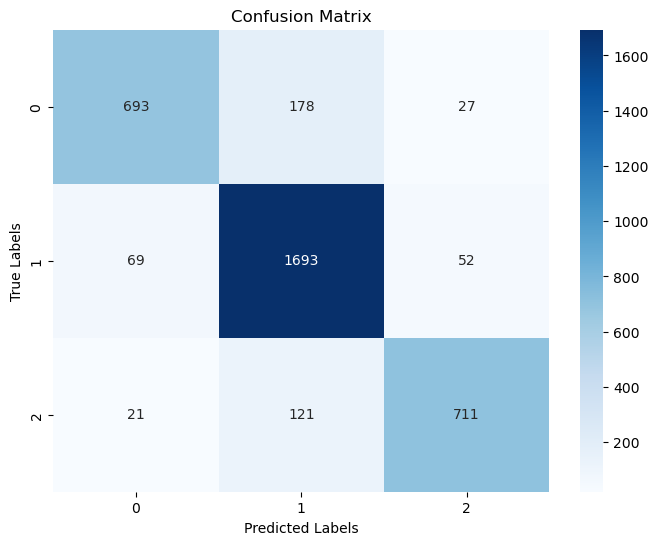

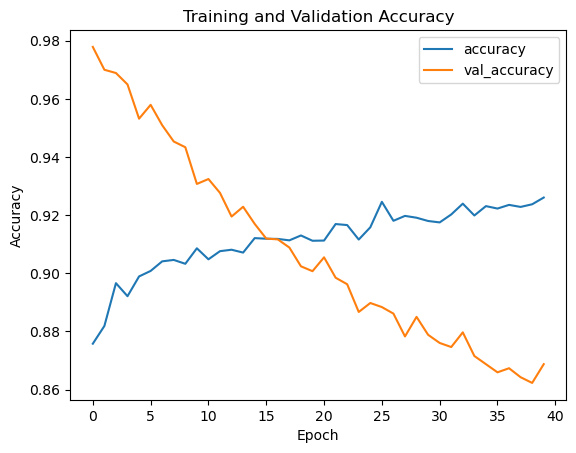

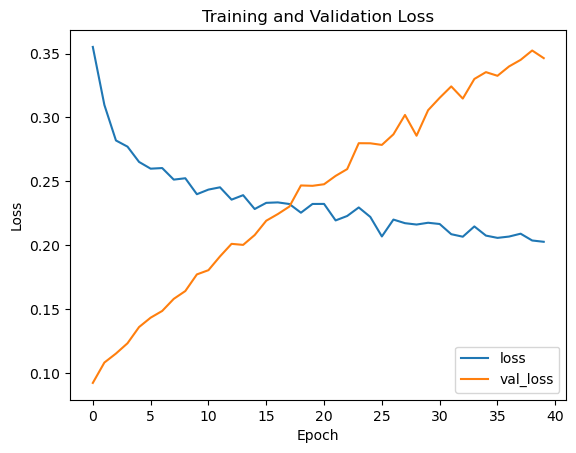

Fold 5
Epoch 1/40
223/223 [==============================] - 2s 8ms/step - loss: 0.3147 - accuracy: 0.8900 - val_loss: 0.0718 - val_accuracy: 0.9849
Epoch 2/40
223/223 [==============================] - 2s 11ms/step - loss: 0.2765 - accuracy: 0.8973 - val_loss: 0.0839 - val_accuracy: 0.9801
Epoch 3/40
223/223 [==============================] - 3s 11ms/step - loss: 0.2573 - accuracy: 0.9011 - val_loss: 0.0909 - val_accuracy: 0.9756
Epoch 4/40
223/223 [==============================] - 3s 12ms/step - loss: 0.2496 - accuracy: 0.9059 - val_loss: 0.1027 - val_accuracy: 0.9675
Epoch 5/40
223/223 [==============================] - 3s 12ms/step - loss: 0.2440 - accuracy: 0.9068 - val_loss: 0.1118 - val_accuracy: 0.9652
Epoch 6/40
223/223 [==============================] - 3s 11ms/step - loss: 0.2408 - accuracy: 0.9091 - val_loss: 0.1197 - val_accuracy: 0.9621
Epoch 7/40
223/223 [==============================] - 2s 9ms/step - loss: 0.2336 - accuracy: 0.9125 - val_loss: 0.1183 - val_accuracy: 0

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8892005610098177, Validation F1 Score: 0.8884896080564267, Validation Precision: 0.8917526907740204, Validation Recall: 0.8892005610098177
              precision    recall  f1-score   support

    Positive       0.89      0.82      0.86       926
    Negative       0.87      0.95      0.90      1800
     Neutral       0.94      0.84      0.89       839

    accuracy                           0.89      3565
   macro avg       0.90      0.87      0.88      3565
weighted avg       0.89      0.89      0.89      3565



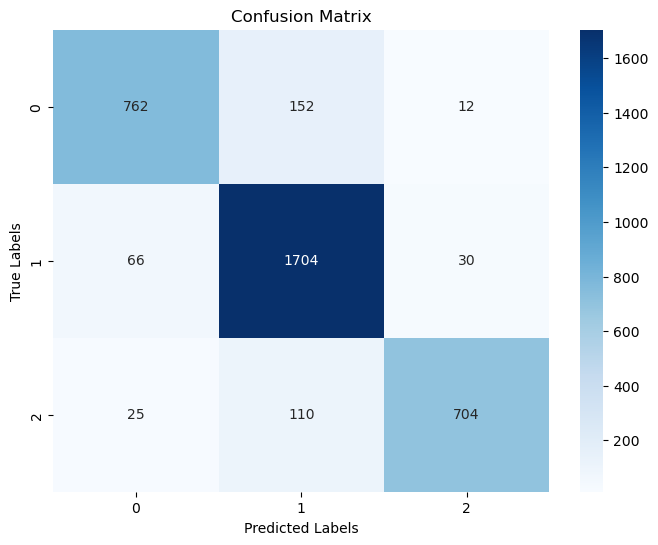

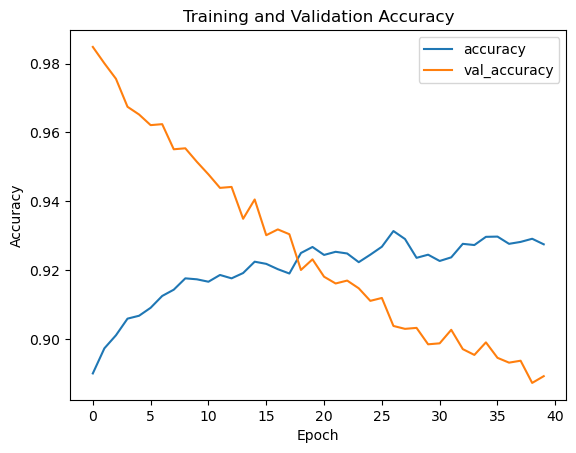

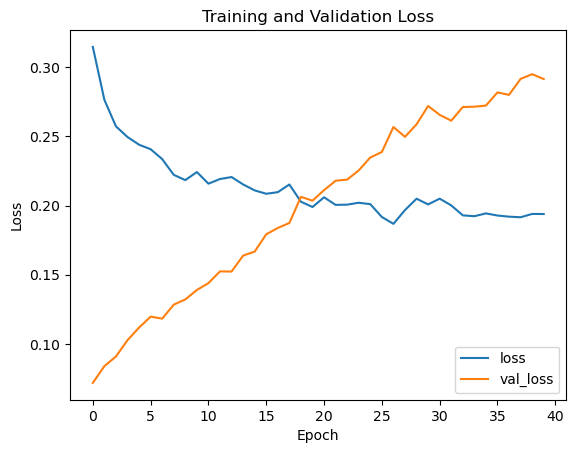

Mean Accuracy: 0.8187188964814176
Mean F1 Score: 0.8171528034392113

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.66      0.60      0.63       877
    Negative       0.73      0.81      0.77      1866
     Neutral       0.75      0.62      0.68       823

    accuracy                           0.72      3566
   macro avg       0.71      0.68      0.69      3566
weighted avg       0.72      0.72      0.72      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.75      0.70      0.73       920
    Negative       0.78      0.85      0.82      1761
     Neutral       0.82      0.73      0.77       885

    accuracy                           0.78      3566
   macro avg       0.79      0.76      0.77      3566
weighted avg       0.78      0.78      0.78      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.8

223/223 [==============================] - 2s 7ms/step - loss: 0.3296 - accuracy: 0.8727 - val_loss: 0.8078 - val_accuracy: 0.7086
Epoch 42/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3168 - accuracy: 0.8732 - val_loss: 0.8044 - val_accuracy: 0.7106
Epoch 43/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3269 - accuracy: 0.8715 - val_loss: 0.8211 - val_accuracy: 0.7120
Epoch 44/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3134 - accuracy: 0.8776 - val_loss: 0.8165 - val_accuracy: 0.7112
Epoch 45/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3135 - accuracy: 0.8800 - val_loss: 0.8411 - val_accuracy: 0.7120
Epoch 46/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3128 - accuracy: 0.8805 - val_loss: 0.8153 - val_accuracy: 0.7145
Epoch 47/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3127 - accuracy: 0.8786 - val_loss: 0.8264 - val_accuracy: 0.7168
Epoch 48/50

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.7089175546831183, Validation F1 Score: 0.7075791785867013, Validation Precision: 0.7077908555467879, Validation Recall: 0.7089175546831183
              precision    recall  f1-score   support

    Positive       0.64      0.62      0.63       877
    Negative       0.74      0.78      0.76      1866
     Neutral       0.71      0.64      0.67       823

    accuracy                           0.71      3566
   macro avg       0.70      0.68      0.69      3566
weighted avg       0.71      0.71      0.71      3566



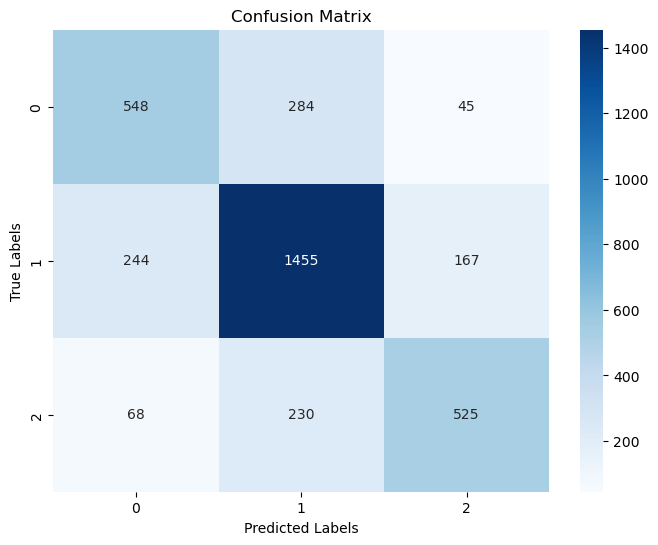

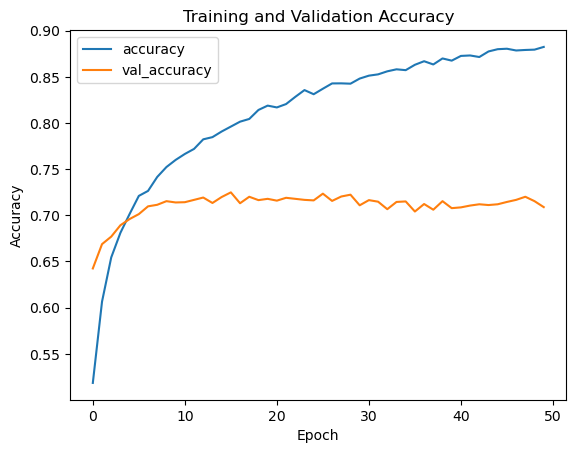

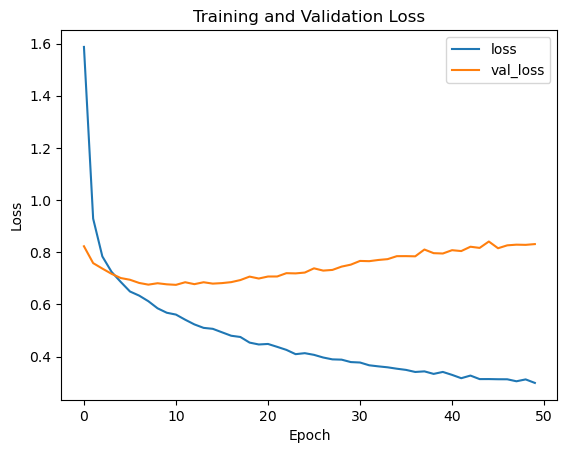

Fold 2
Epoch 1/50
223/223 [==============================] - 2s 7ms/step - loss: 0.4816 - accuracy: 0.8274 - val_loss: 0.1948 - val_accuracy: 0.9464
Epoch 2/50
223/223 [==============================] - 1s 7ms/step - loss: 0.4335 - accuracy: 0.8376 - val_loss: 0.2203 - val_accuracy: 0.9341
Epoch 3/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3954 - accuracy: 0.8495 - val_loss: 0.2362 - val_accuracy: 0.9237
Epoch 4/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3874 - accuracy: 0.8498 - val_loss: 0.2540 - val_accuracy: 0.9100
Epoch 5/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3682 - accuracy: 0.8565 - val_loss: 0.2650 - val_accuracy: 0.9058
Epoch 6/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3702 - accuracy: 0.8586 - val_loss: 0.2905 - val_accuracy: 0.8895
Epoch 7/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3591 - accuracy: 0.8571 - val_loss: 0.2889 - val_accuracy: 0.8867

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 3ms/step
Validation Accuracy: 0.7865956253505328, Validation F1 Score: 0.7845540710148531, Validation Precision: 0.7884234985464393, Validation Recall: 0.7865956253505328
              precision    recall  f1-score   support

    Positive       0.78      0.68      0.73       920
    Negative       0.77      0.87      0.82      1761
     Neutral       0.83      0.73      0.78       885

    accuracy                           0.79      3566
   macro avg       0.79      0.76      0.77      3566
weighted avg       0.79      0.79      0.78      3566



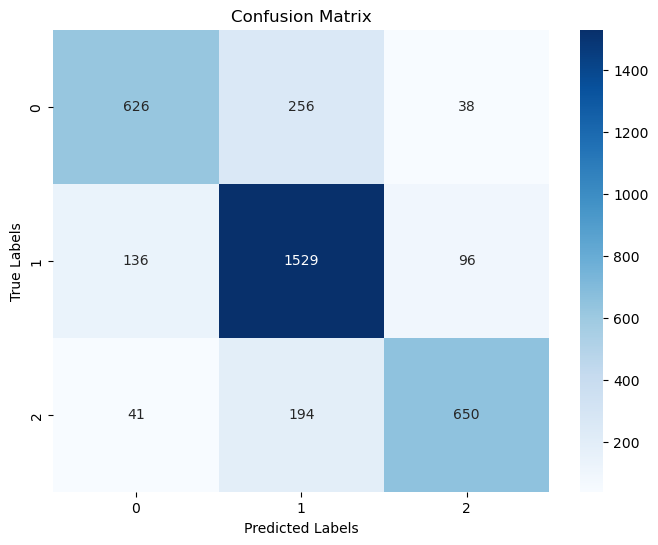

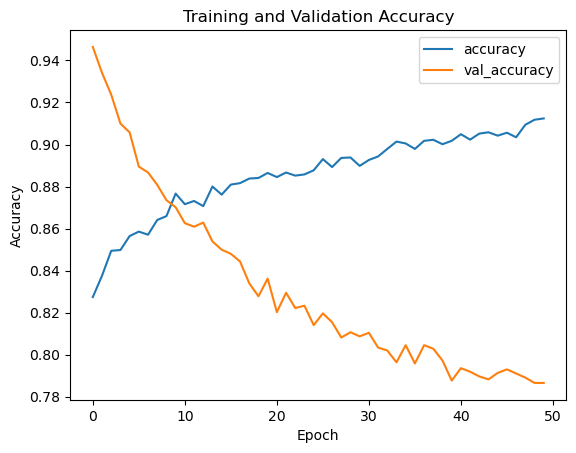

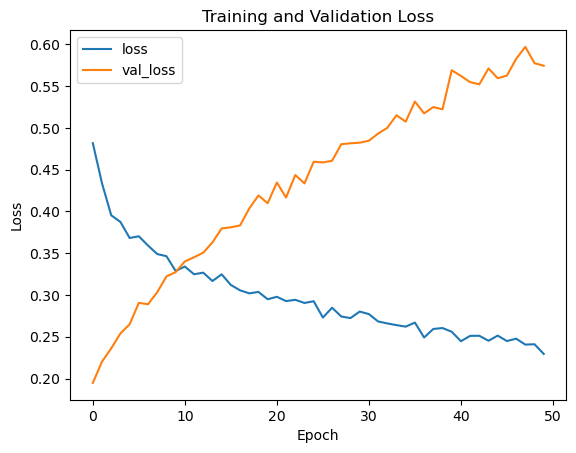

Fold 3
Epoch 1/50
223/223 [==============================] - 2s 8ms/step - loss: 0.3911 - accuracy: 0.8647 - val_loss: 0.1098 - val_accuracy: 0.9778
Epoch 2/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3560 - accuracy: 0.8643 - val_loss: 0.1305 - val_accuracy: 0.9669
Epoch 3/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3304 - accuracy: 0.8792 - val_loss: 0.1417 - val_accuracy: 0.9610
Epoch 4/50
223/223 [==============================] - 1s 7ms/step - loss: 0.3080 - accuracy: 0.8799 - val_loss: 0.1540 - val_accuracy: 0.9540
Epoch 5/50
223/223 [==============================] - 1s 6ms/step - loss: 0.2954 - accuracy: 0.8865 - val_loss: 0.1635 - val_accuracy: 0.9476
Epoch 6/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2896 - accuracy: 0.8880 - val_loss: 0.1715 - val_accuracy: 0.9470
Epoch 7/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2811 - accuracy: 0.8896 - val_loss: 0.1809 - val_accuracy: 0.9377

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8412787436904094, Validation F1 Score: 0.8399356573298646, Validation Precision: 0.842673237524887, Validation Recall: 0.8412787436904094
              precision    recall  f1-score   support

    Positive       0.83      0.75      0.79       932
    Negative       0.83      0.91      0.87      1806
     Neutral       0.89      0.80      0.84       828

    accuracy                           0.84      3566
   macro avg       0.85      0.82      0.83      3566
weighted avg       0.84      0.84      0.84      3566



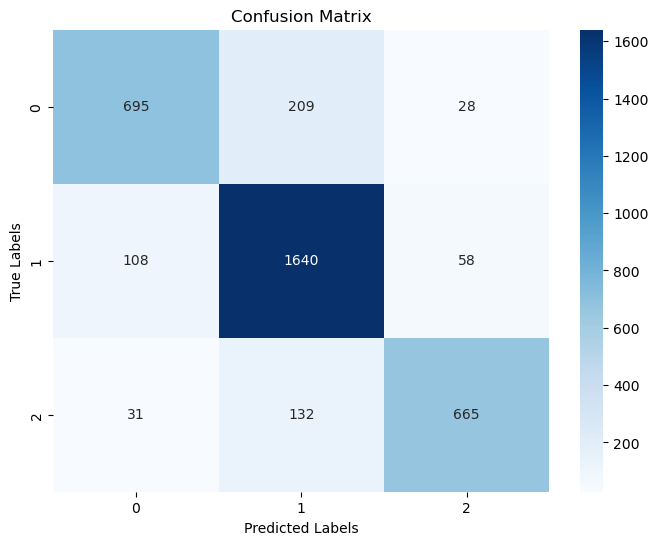

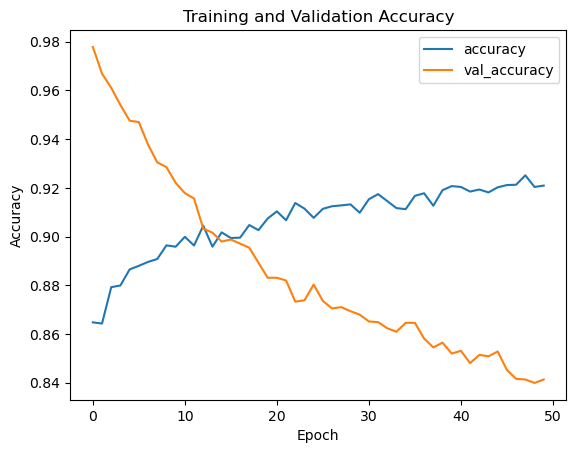

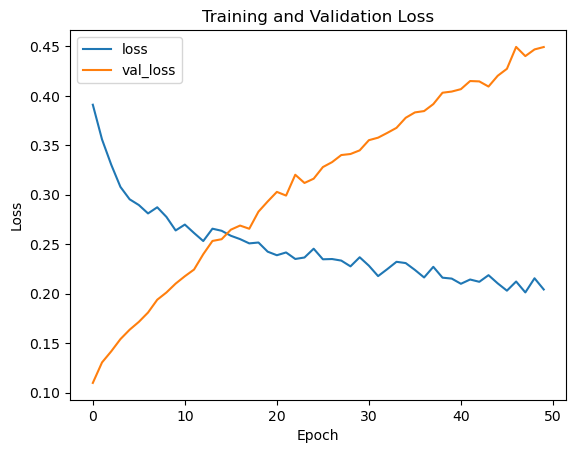

Fold 4
Epoch 1/50
223/223 [==============================] - 2s 8ms/step - loss: 0.3553 - accuracy: 0.8781 - val_loss: 0.0763 - val_accuracy: 0.9849
Epoch 2/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3036 - accuracy: 0.8862 - val_loss: 0.0873 - val_accuracy: 0.9792
Epoch 3/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2890 - accuracy: 0.8903 - val_loss: 0.1008 - val_accuracy: 0.9728
Epoch 4/50
223/223 [==============================] - 2s 8ms/step - loss: 0.2560 - accuracy: 0.9025 - val_loss: 0.1042 - val_accuracy: 0.9700
Epoch 5/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2563 - accuracy: 0.9033 - val_loss: 0.1117 - val_accuracy: 0.9669
Epoch 6/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2573 - accuracy: 0.9026 - val_loss: 0.1195 - val_accuracy: 0.9649
Epoch 7/50
223/223 [==============================] - 1s 7ms/step - loss: 0.2450 - accuracy: 0.9122 - val_loss: 0.1302 - val_accuracy: 0.9579

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 2ms/step
Validation Accuracy: 0.8712482468443198, Validation F1 Score: 0.8702365468439198, Validation Precision: 0.8724608222557794, Validation Recall: 0.8712482468443198
              precision    recall  f1-score   support

    Positive       0.88      0.79      0.83       898
    Negative       0.86      0.93      0.89      1814
     Neutral       0.90      0.83      0.87       853

    accuracy                           0.87      3565
   macro avg       0.88      0.85      0.86      3565
weighted avg       0.87      0.87      0.87      3565



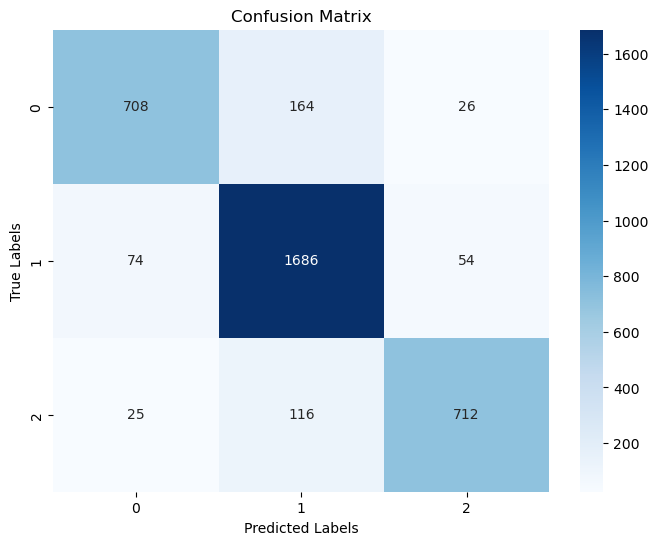

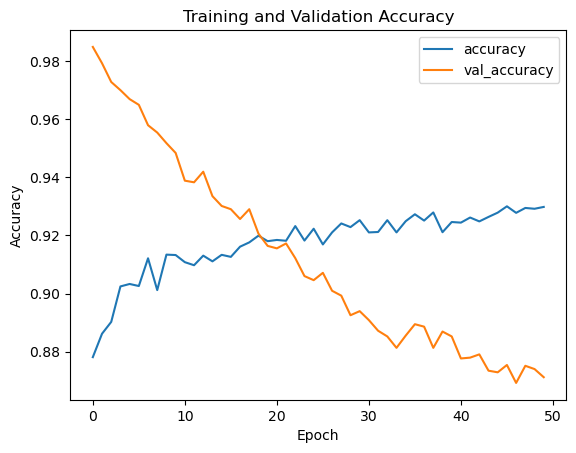

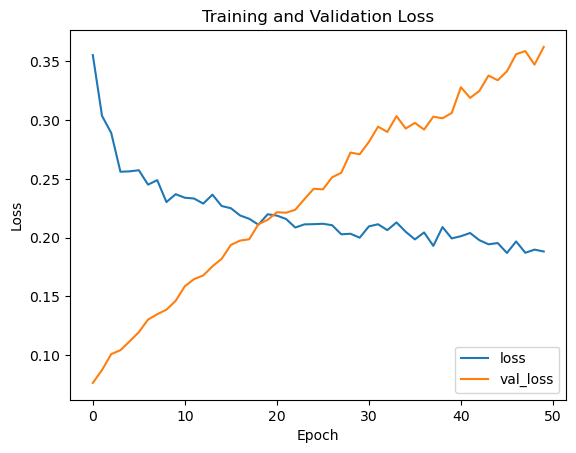

Fold 5
Epoch 1/50
223/223 [==============================] - 2s 7ms/step - loss: 0.3240 - accuracy: 0.8910 - val_loss: 0.0675 - val_accuracy: 0.9863
Epoch 2/50
223/223 [==============================] - 1s 6ms/step - loss: 0.2760 - accuracy: 0.8974 - val_loss: 0.0789 - val_accuracy: 0.9809
Epoch 3/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2501 - accuracy: 0.9076 - val_loss: 0.0803 - val_accuracy: 0.9815
Epoch 4/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2449 - accuracy: 0.9091 - val_loss: 0.0883 - val_accuracy: 0.9778
Epoch 5/50
223/223 [==============================] - 2s 7ms/step - loss: 0.2278 - accuracy: 0.9157 - val_loss: 0.0916 - val_accuracy: 0.9756
Epoch 6/50
223/223 [==============================] - 1s 7ms/step - loss: 0.2224 - accuracy: 0.9136 - val_loss: 0.0991 - val_accuracy: 0.9697
Epoch 7/50
223/223 [==============================] - 1s 7ms/step - loss: 0.2212 - accuracy: 0.9159 - val_loss: 0.1057 - val_accuracy: 0.9677

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


112/112 [==============================] - 0s 3ms/step
Validation Accuracy: 0.8959326788218794, Validation F1 Score: 0.8955523811376693, Validation Precision: 0.8965639245106076, Validation Recall: 0.8959326788218794
              precision    recall  f1-score   support

    Positive       0.90      0.85      0.87       926
    Negative       0.89      0.93      0.91      1800
     Neutral       0.92      0.86      0.89       839

    accuracy                           0.90      3565
   macro avg       0.90      0.88      0.89      3565
weighted avg       0.90      0.90      0.90      3565



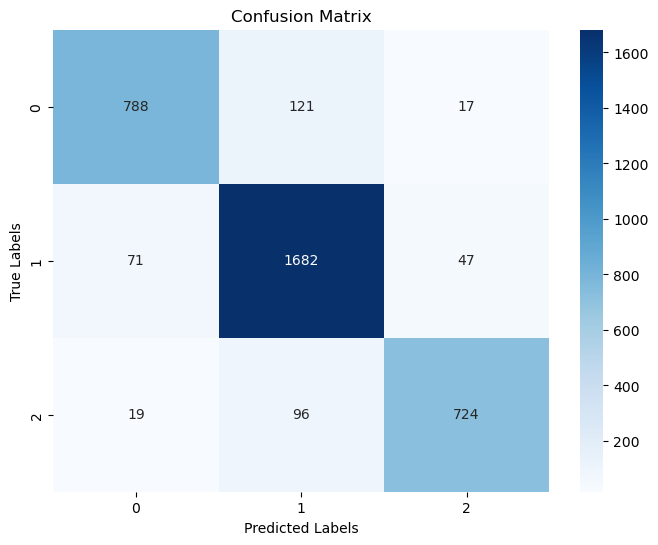

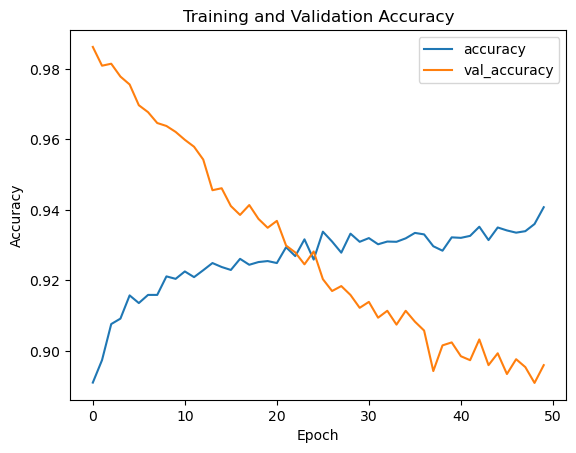

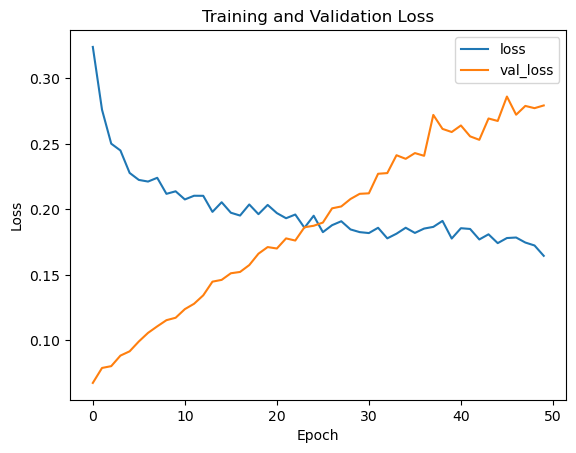

Mean Accuracy: 0.820794569878052
Mean F1 Score: 0.8195715669826017

Fold 1 Classification Report:
              precision    recall  f1-score   support

    Positive       0.64      0.62      0.63       877
    Negative       0.74      0.78      0.76      1866
     Neutral       0.71      0.64      0.67       823

    accuracy                           0.71      3566
   macro avg       0.70      0.68      0.69      3566
weighted avg       0.71      0.71      0.71      3566


Fold 2 Classification Report:
              precision    recall  f1-score   support

    Positive       0.78      0.68      0.73       920
    Negative       0.77      0.87      0.82      1761
     Neutral       0.83      0.73      0.78       885

    accuracy                           0.79      3566
   macro avg       0.79      0.76      0.77      3566
weighted avg       0.79      0.79      0.78      3566


Fold 3 Classification Report:
              precision    recall  f1-score   support

    Positive       0.83

C:\Users\ekaad\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from graphviz import Digraph
from sklearn.metrics import precision_score

def create_model():
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_len,
                                weights=[embedding_matrix], trainable=False)(input_layer)
    conv_layer = Conv1D(128, 3, activation='relu')(embedding_layer)
    pooling_layer = GlobalMaxPooling1D()(conv_layer)
    dropout_layer = Dropout(0.5)(pooling_layer)
    output_layer = Dense(3, activation='softmax')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

## Start Modeling
model = create_model()

# Start Modeling
best_model_metrics = {
    'f1_score': 0,
    'precision': 0,
    'accuracy': 0,
    'recall': 0,
    'support': 0,
    'model': None,
    'epoch': 0
}

for epoch in range(10, 51, 10):
    print(f'Epochs: {epoch}')


    accuracy_scores = []
    f1_scores = []
    precisions = []
    recalls = []
    classification_reports = []  # Store classification reports for each fold

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_indices, val_indices) in enumerate(kfold.split(text, y), 1):
        print(f'Fold {fold}')

        X_train, X_val = text[train_indices], text[val_indices]
        y_train, y_val = y[train_indices], y[val_indices]

        model = create_model()

        # Train model or load model from the previous fold
        if fold > 1:
            model = load_model(f"model_fold{fold - 1}.h5")

        # Train model
        history = model.fit(X_train, y_train, epochs=epoch, batch_size=64, validation_data=(X_val, y_val))
        model.save(f"model_fold{fold}.h5")


        # Evaluate model
        y_pred = np.argmax(model.predict(X_val), axis=1)
        accuracy = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='weighted')
        precision = precision_score(y_val, y_pred, average='weighted')  # Add this line for precision
        recall = recall_score(y_val, y_pred, average='weighted')  # Add this line for recall
        support = len(y_val)  # Add this line for support
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        precisions.append(precision)  # Add precision to the list
        recalls.append(recall)  # Add recall to the list
        print(f"Validation Accuracy: {accuracy}, Validation F1 Score: {f1}, Validation Precision: {precision}, Validation Recall: {recall}")



        # Generate classification report with labels
        report = classification_report(y_val, y_pred, labels=[0, 1, 2], target_names=['Positive', 'Negative', 'Neutral'])
        classification_reports.append(report)
        print(report)

        # Plot confusion matrix, save plots, and show
        plot_confusion_matrix(y_val, y_pred, labels=[0, 1, 2])

        # Plot training history, save plots, and show
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

        # Generate flowchart
        dot = Digraph(comment='Model Flowchart')
        dot.node('A', 'Input')
        dot.node('B', 'Embedding')
        dot.node('C', 'Conv1D')
        dot.node('D', 'GlobalMaxPooling1D')
        dot.node('E', 'Dropout')
        dot.node('F', 'Dense')

        dot.edges(['AB', 'BC', 'CD', 'DE', 'EF'])
        dot.render(f'flowchart_fold{fold}', format='png', cleanup=True)

    # Print mean evaluation metrics across all folds
    print(f'Mean Accuracy: {np.mean(accuracy_scores)}')
    print(f'Mean F1 Score: {np.mean(f1_scores)}')

    # Print the classification reports for each fold
    for idx, report in enumerate(classification_reports, 1):
        print(f"\nFold {idx} Classification Report:")
        print(report)

    # Compare with best model so far
        if f1 > best_model_metrics['f1_score'] or \
                (f1 == best_model_metrics['f1_score'] and accuracy > best_model_metrics['accuracy']) or \
                (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                 precision > best_model_metrics['precision']) or \
                (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                 precision == best_model_metrics['precision'] and recall > best_model_metrics['recall']) or \
                (f1 == best_model_metrics['f1_score'] and accuracy == best_model_metrics['accuracy'] and
                 precision == best_model_metrics['precision'] and recall == best_model_metrics['recall'] and
                 support > best_model_metrics['support']):
            best_model_metrics['f1_score'] = f1
            best_model_metrics['precision'] = precision
            best_model_metrics['accuracy'] = accuracy
            best_model_metrics['recall'] = recall
            best_model_metrics['support'] = support
            best_model_metrics['model'] = model
            best_model_metrics['epoch'] = epoch

    print(f'Best Model Metrics for Epoch {epoch}:')
    print(best_model_metrics)

# Save the best model
best_model_metrics['model'].save(f"best_model_epoch_{best_model_metrics['epoch']}.h5")
print(f'Best model saved as: best_model_epoch_{best_model_metrics["epoch"]}.h5')

In [ ]:
data = pd.read_csv('dataset_roberta_Cardiffnlp.csv',delimiter=';')
data

text     label
0                            prabowo pol mbak nana putar  negative
1      bismillah bidznilah anies presiden amin iya ro...  positive
2      libat publik libat publik bahasa mu mumet ambi...  negative
3                   lihat muka anies senang anjt prabowo  positive
4      anak muda indonesia butuh pimpin pandai rangka...  positive
...                                                  ...       ...
14006                  nathanizqian orang jawa tau kakak   neutral
14007      nampancoklat orang jateng kadrun masuk kepala  negative
14008  prabowo uzurngurus rumah tanga beranta urus ne...  positive
14009  prabowo calon presideen prabowo kerja capai ta...  positive
14010       aldi taher prosperity of indonesia alditaher  positive

[14011 rows x 2 columns]

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
sentimen_negatif = data[data['label'] == 'negative']['text'].str.cat(sep=' ')
sentimen_positif = data[data['label'] == 'positive']['text'].str.cat(sep=' ')
sentimen_netral = data[data['label'] == 'neutral']['text'].str.cat(sep=' ')

In [ ]:
def create_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, random_state=42, max_font_size=100, background_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

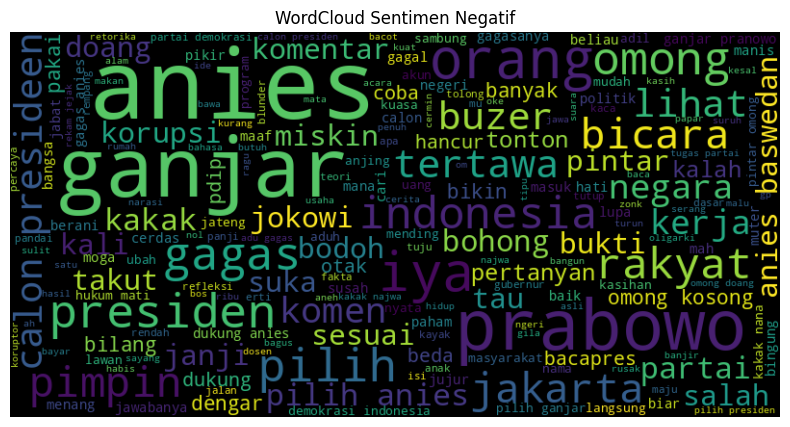

In [ ]:
# Membuat WordCloud untuk sentimen negatif
create_wordcloud(sentimen_negatif, 'WordCloud Sentimen Negatif')

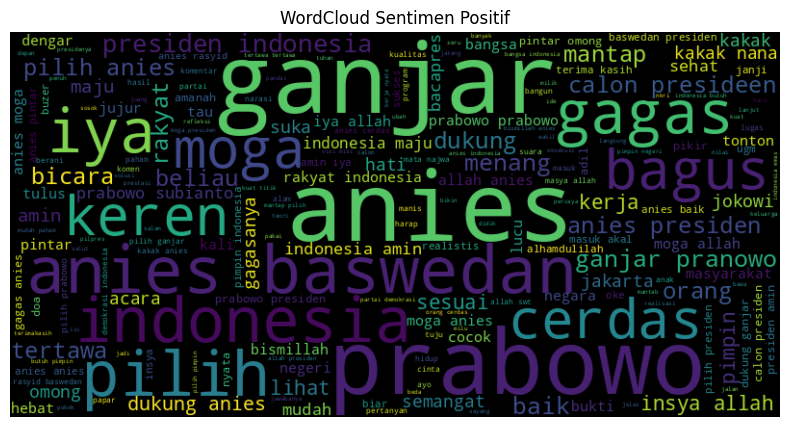

In [ ]:
# Membuat WordCloud untuk sentimen positif
create_wordcloud(sentimen_positif, 'WordCloud Sentimen Positif')

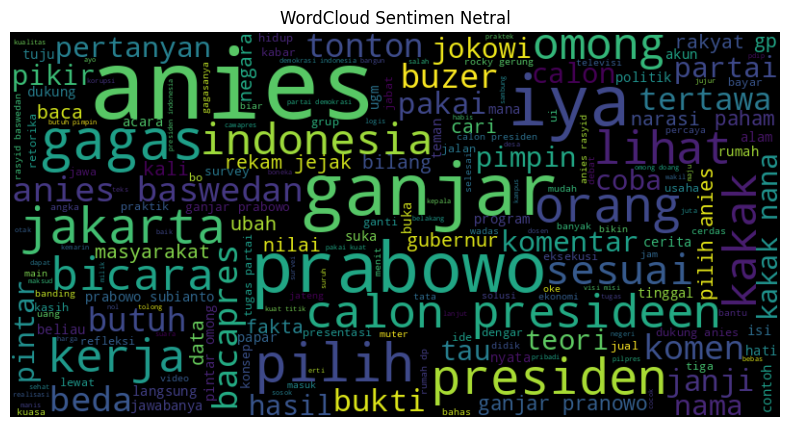

In [ ]:
# Membuat WordCloud untuk sentimen netral
create_wordcloud(sentimen_netral, 'WordCloud Sentimen Netral')

In [19]:
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to predict new texts and evaluate their accuracy
def predict_and_evaluate(model, tokenizer, max_len, new_texts, true_labels=None):
    # Tokenize and pad the new texts
    new_sequences = tokenizer.texts_to_sequences(new_texts)
    new_padded_sequences = pad_sequences(new_sequences, maxlen=max_len, padding='post')

    # Perform prediction using the model
    predicted_probabilities = model.predict(new_padded_sequences)

    # Get the predicted labels
    predicted_labels_index = np.argmax(predicted_probabilities, axis=1)
    predicted_labels = label_encoder.classes_[predicted_labels_index]

    # Display the prediction results
    for i, new_text in enumerate(new_texts):
        print(f'Text: {new_text}')
        print(f'Predicted Label: {predicted_labels[i]}')
        print('Prediction Probabilities:')
        for label, prob in zip(label_encoder.classes_, predicted_probabilities[i]):
            print(f'{label}: {prob:.4f}')

        print('\n')

# Example new texts and true labels (optional)
new_texts = [
    "Pembangunan saat ini semakin bagus dan keren.",
    "Proyek ini tidak efisien dan mengecewakan.",
    "Film tersebut sangat menginspirasi dan menyentuh hati."
]
true_labels = ['positif', 'negatif', 'positif']

# Predict and evaluate each new text
predict_and_evaluate(model, tokenizer, max_len, new_texts, true_labels)


1/1 [==============================] - 0s 14ms/step
Text: Pembangunan saat ini semakin bagus dan keren.
Predicted Label: positive
Prediction Probabilities:
negative: 0.0041
neutral: 0.0048
positive: 0.9910


Text: Proyek ini tidak efisien dan mengecewakan.
Predicted Label: negative
Prediction Probabilities:
negative: 0.4037
neutral: 0.2390
positive: 0.3573


Text: Film tersebut sangat menginspirasi dan menyentuh hati.
Predicted Label: negative
Prediction Probabilities:
negative: 0.3649
neutral: 0.2882
positive: 0.3469


